In [1]:
import os
import pandas as pd
import numpy as np
import time
import multiprocessing
import matplotlib.pyplot as plt
from haversine import haversine
import json
from collections import defaultdict
from glob import glob
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
from geopy.distance import great_circle

In [2]:
cbg_geom_fp = '2019cbg.geojson'
t0 = time.time()
cbg_geom_df = gpd.read_file(cbg_geom_fp)
print(f'CBG geometry data loading time is {time.time() - t0}')
cbg_geom_df = cbg_geom_df.to_crs('EPSG:2263')
cbg_geom_df['centroid'] = cbg_geom_df.centroid
cbg_geom_df.set_geometry('centroid', inplace=True)
cbg_geom_df = cbg_geom_df.to_crs('EPSG:4326')

CBG geometry data loading time is 452.20016860961914


In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import time
import json

def process_city_data(city_name):
    # Load US city boundaries
    us_city500_fp = './demo_code/Facility_distribution/500US_Cities_Bond/CityBoundaries.shp'
    us500city = gpd.read_file(us_city500_fp)
    us_500cities = us500city.to_crs(epsg=4326)
    
    city_boundary = us_500cities[us_500cities['NAME'] == city_name].geometry.iloc[0]
    
    # Ensure centroids are Points
    if not isinstance(cbg_geom_df['centroid'].iloc[0], Point):
        cbg_geom_df['centroid'] = cbg_geom_df['centroid'].apply(lambda x: Point(x))
    
    cbg_geom_df['CensusBlockGroup'] = cbg_geom_df['CensusBlockGroup'].astype(str)
    cbg_in_city = cbg_geom_df[cbg_geom_df['centroid'].apply(lambda x: x.within(city_boundary))]
    cbg_in_city.set_index('CensusBlockGroup', inplace=True)
    
    # Load population data
    cbg_pop_fp = 'cbg_b01.csv'
    dtype_dic = {'census_block_group': str}
    cbg_pop_df = pd.read_csv(cbg_pop_fp, dtype=dtype_dic)
    
    cbg_in_city = cbg_in_city.reset_index()
    cbg_in_city['CensusBlockGroup'] = cbg_in_city['CensusBlockGroup'].astype(str)
    cbg_pop_df['census_block_group'] = cbg_pop_df['census_block_group'].astype(str)
    
    merged_df = pd.merge(cbg_in_city, 
                         cbg_pop_df[['census_block_group', 'B01001e1']], 
                         how='left', 
                         left_on='CensusBlockGroup', 
                         right_on='census_block_group')
    
    merged_df.drop(columns=['census_block_group'], inplace=True)
    merged_df.rename(columns={'B01001e1': 'population'}, inplace=True)
    merged_df.set_index('CensusBlockGroup', inplace=True)
    cbg_in_city = merged_df

    cbg_in_city = cbg_in_city.set_geometry('centroid', crs='EPSG:4326')
    cbg_to_centroid = {str(index): row['centroid'] for index, row in cbg_in_city.iterrows()}
    
    # Load SafeGraph data for the city
    filenames = [f'2021{month:02d}_{city_name}.csv' for month in range(1, 12)]
    year2021_data = pd.DataFrame()
    
    for filename in filenames:
        df = pd.read_csv(filename)
        year2021_data = pd.concat([year2021_data, df], ignore_index=True)
    
    year2021_data = year2021_data[year2021_data['city'] == city_name]
    
    # Filter invalid data
    year2021_data = year2021_data.dropna(subset=['naics_code', 'poi_cbg', 'visitor_home_cbgs', 'longitude', 'latitude'])
    
    # Convert 'poi_cbg' to string, remove decimal points, and ensure 12 characters with leading zeros
    year2021_data['poi_cbg'] = year2021_data['poi_cbg'].astype(str).str.split('.').str[0].str.zfill(12)

    # Filter visitor data
    year2021_data['visitor_home_cbgs'] = year2021_data['visitor_home_cbgs'].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x)

    newdata = year2021_data[year2021_data['visitor_home_cbgs'].apply(lambda x: bool(x))].copy()

    # Group by 'placekey' to avoid duplicates
    newdata = newdata.groupby('placekey').agg({
        'poi_cbg': 'first',
        'visitor_home_cbgs': lambda x: {k: sum(d.get(k, 0) for d in x if isinstance(d, dict)) for k in set(k for d in x for k in d.keys())},
        'naics_code': 'first',
        'longitude': 'first',
        'latitude': 'first',
        'raw_visit_counts': 'sum',
        'raw_visitor_counts': 'sum',
    }).reset_index()
    
    # Ensure no NaN after aggregation
    newdata = newdata.dropna(subset=['poi_cbg', 'visitor_home_cbgs'])
    newdata['visit_visitor_ratio'] = newdata.apply(
        lambda row: row['raw_visit_counts'] / row['raw_visitor_counts'] if row['raw_visitor_counts'] != 0 else 0, axis=1)
    
    # Adjust visitor counts
    newdata['visit_home_cbgs'] = newdata.apply(
        lambda row: {k: v * row['visit_visitor_ratio'] for k, v in row['visitor_home_cbgs'].items()} 
        if isinstance(row['visitor_home_cbgs'], dict) else {}, axis=1)
    
    # Create geometry
    newdata['geometry'] = newdata.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    newdata = gpd.GeoDataFrame(newdata, geometry='geometry', crs='EPSG:4326')
    
    # Spatial join with CBG geometry
    newdata = gpd.sjoin(newdata, cbg_in_city.set_geometry('geometry', crs='EPSG:4326'), how='left', predicate='intersects')
    
    # Filter by poi_cbg within city
    newdata = newdata[newdata['poi_cbg'].isin(cbg_in_city.index)]
    
    # Assign poi types
    naics_to_poi_type = {
        '621111': 'Healthcare',
        '621112': 'Healthcare',
        '621410': 'Healthcare',
        '621492': 'Healthcare',
        '621493': 'Healthcare',
        '621498': 'Healthcare',
        '622110': 'Healthcare',
        '446110': 'Drugstores',
        '611110': 'Schools',
        '813110': 'Religious Organizations',
        '722511': 'Restaurants',
        '722513': 'Restaurants',
        '722514': 'Restaurants',
        '722515': 'Restaurants',
        '445110': 'Groceries',
        '445120': 'Groceries',
        '712190': 'Parks',
        '711190': 'Cultural Institutions',
        '713110': 'Cultural Institutions',
        '712110': 'Cultural Institutions',
        '491110': 'Services',
        '522110': 'Services',
        '812111': 'Services',
        '812112': 'Services',
        '812113': 'Services',
        '812320': 'Services'
    }
    
    newdata['poi_type'] = newdata['naics_code'].apply(lambda x: naics_to_poi_type.get(str(int(x)), 'Other') if pd.notnull(x) else 'Other')
    newdata = newdata[newdata['poi_type'] != 'Other']
    
    # Calculate 15-minute access
    cbg_isochrones = gpd.read_file('cbg_isochrones.geojson')
    cbg_isochrones['cbg_id'] = cbg_isochrones['cbg_id'].astype(str)
    cbg_ids = cbg_in_city.index.astype(str).tolist()
    city_isochrones = cbg_isochrones[cbg_isochrones['cbg_id'].isin(cbg_ids)]
    
    results = []
    for idx, cbg in city_isochrones.iterrows():
        cbg_polygon = cbg['geometry']
        cbg_id = cbg['cbg_id']
        poi_in_cbg = newdata[newdata.within(cbg_polygon)]
        poi_counts_by_type = poi_in_cbg['poi_type'].value_counts().to_dict() if 'poi_type' in poi_in_cbg.columns else {}
        total_poi_count = poi_in_cbg.shape[0]
        results.append({
            'cbg_id': cbg_id,
            'total_poi_count': total_poi_count,
            **poi_counts_by_type
        })
    
    No_Facility = pd.DataFrame(results)
    
    # Compute trip data
    trip_counts = newdata['poi_type'].value_counts()
    trip_percentages = trip_counts / trip_counts.sum()
    trip_data = trip_percentages.reset_index()
    trip_data.columns = ['category', 'percentage_of_trips']
    trip_data['weight'] = trip_data['percentage_of_trips'] / trip_data['percentage_of_trips'].sum()
    
    for col in No_Facility.columns[2:]:
        No_Facility[f'{col}_percentile'] = No_Facility[col].rank(pct=True) * 100
    
    for category in trip_data['category']:
        if f'{category}_percentile' in No_Facility.columns:
            No_Facility[f'{category}_access'] = No_Facility[f'{category}_percentile'] * trip_data[trip_data['category'] == category]['weight'].values[0]
    
    No_Facility['access_index'] = No_Facility[[f'{category}_access' for category in trip_data['category']]].sum(axis=1)
    
    # Merge access index calculation results
    merged_access_df = pd.merge(cbg_in_city[['population']], 
                                No_Facility[['cbg_id', 'access_index']], 
                                left_index=True, 
                                right_on='cbg_id', 
                                how='inner')

    merged_access_df['weighted_access'] = merged_access_df['access_index'] * merged_access_df['population']

    if merged_access_df['population'].sum() > 0:
        access_index = merged_access_df['weighted_access'].sum() / merged_access_df['population'].sum()
    else:
        access_index = 0

    print(f"{city_name} access index: {access_index:.4f}")
    
    # Calculate the usage index with demand as the weight
    results = []
    for idx, cbg in city_isochrones.iterrows():
        target_cbg_id = cbg['cbg_id']
        target_cbg_polygon = cbg['geometry']
        
        # Filter records from target CBG
        target_rows = newdata[newdata['visit_home_cbgs'].apply(lambda x: target_cbg_id in x)]
        
        within_1_25km_count = 0
        outside_1_25km_count = 0
        total_visitors = 0
        
        for idx, row in target_rows.iterrows():
            visitor_count = row['visit_home_cbgs'][target_cbg_id]
            total_visitors += visitor_count
            destination_point = row['geometry']
            
            if destination_point.within(target_cbg_polygon):
                within_1_25km_count += visitor_count
            else:
                outside_1_25km_count += visitor_count
        
        within_ratio = within_1_25km_count / total_visitors if total_visitors > 0 else 0
        
        results.append({
            'cbg_id': target_cbg_id,
            'total_visitors': total_visitors,
            'within_1_25km_count': within_1_25km_count,
            'outside_1_25km_count': outside_1_25km_count,
            'within_ratio': within_ratio
        })
    
    cbg_visitor_ratios = pd.DataFrame(results)
    cbg_visitor_ratios['cbg_id'] = cbg_visitor_ratios['cbg_id'].astype(str)
    cbg_in_city.index = cbg_in_city.index.astype(str)

    merged_usage_df = pd.merge(cbg_in_city[['population']], 
                               cbg_visitor_ratios[['cbg_id', 'within_ratio', 'total_visitors']], 
                               left_index=True, 
                               right_on='cbg_id', 
                               how='left')

    merged_usage_df['within_ratio'] = merged_usage_df['within_ratio'].fillna(0)

    # Calculate the weighted usage index using total_visitors as the demand
    if merged_usage_df['total_visitors'].sum() > 0:
        merged_usage_df['weighted_usage'] = merged_usage_df['within_ratio'] * merged_usage_df['total_visitors']
        usage_index = merged_usage_df['weighted_usage'].sum() / merged_usage_df['total_visitors'].sum()
    else:
        usage_index = 0

    print(f"{city_name} usage index (based on demand): {usage_index:.4f}")
    
    # Ensure merged_access_df and merged_usage_df have consistent lengths
    common_index = merged_access_df.index.intersection(merged_usage_df.index)
    merged_access_df = merged_access_df.loc[common_index]
    merged_usage_df = merged_usage_df.loc[common_index]

    # Plotting the scatter plot of Access vs Usage
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_access_df['access_index'], merged_usage_df['within_ratio'], alpha=0.5)
    plt.title(f'Scatter Plot of Access vs Usage in {city_name}')
    plt.xlabel('Access Index')
    plt.ylabel('Usage Index')
    plt.grid(True)
    plt.show()

    return access_index, usage_index, merged_access_df, merged_usage_df


def process_multiple_cities(city_names):
    access_indices = []
    usage_indices = []
    city_labels = []

    for city_name in city_names:
        access_index, usage_index, merged_access_df, merged_usage_df = process_city_data(city_name)
        access_indices.append(access_index)
        usage_indices.append(usage_index)
        city_labels.append(city_name)

    # Plotting the scatter plot for all cities
    plt.figure(figsize=(12, 8))
    plt.scatter(access_indices, usage_indices, alpha=0.6, color='blue')

    for i, label in enumerate(city_labels):
        plt.text(access_indices[i], usage_indices[i], label, fontsize=9, ha='right')

    plt.title('Scatter Plot of Access vs Usage Across Multiple Cities')
    plt.xlabel('Access Index')
    plt.ylabel('Usage Index')
    plt.grid(True)
    plt.show()

    # Return the data for further use if needed
    return access_indices, usage_indices, city_labels

def process_and_save_city_data(city_names, csv_file='city_data.csv'):
    # 如果 CSV 文件存在，先读取已有的数据
    if os.path.exists(csv_file):
        existing_data = pd.read_csv(csv_file)
        existing_cities = existing_data['city_name'].tolist()
    else:
        existing_data = pd.DataFrame(columns=['city_name', 'access_index', 'usage_index'])
        existing_cities = []

    new_data = []

    for city_name in city_names:
        if city_name in existing_cities:
            print(f"{city_name} 已经存在，跳过计算")
            continue

        # 计算新城市的 access 和 usage 指数
        access_index, usage_index, _, _ = process_city_data(city_name)
        
        # 将新的城市数据添加到新数据列表中
        new_data.append({
            'city_name': city_name,
            'access_index': access_index,
            'usage_index': usage_index
        })

    # 如果有新的数据，则将其添加到现有数据中并保存
    if new_data:
        new_data_df = pd.DataFrame(new_data)
        combined_data = pd.concat([existing_data, new_data_df], ignore_index=True)

        # 将合并后的数据保存到 CSV 文件中
        combined_data.to_csv(csv_file, index=False)
        print(f"数据已更新并保存到 {csv_file}")
    else:
        combined_data = existing_data
        print(f"没有新数据要保存")

    # 绘制更新后的散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(combined_data['access_index'], combined_data['usage_index'], alpha=0.5, color='blue')

    for i, label in enumerate(combined_data['city_name']):
        plt.text(combined_data['access_index'][i], combined_data['usage_index'][i], label, fontsize=9, ha='right')

    plt.title('Scatter Plot of Access vs Usage Across Multiple Cities')
    plt.xlabel('Access Index')
    plt.ylabel('Usage Index')
    plt.grid(True)
    plt.show()

    return combined_data

New York access index: 34.7573
New York usage index (based on demand): 0.2510


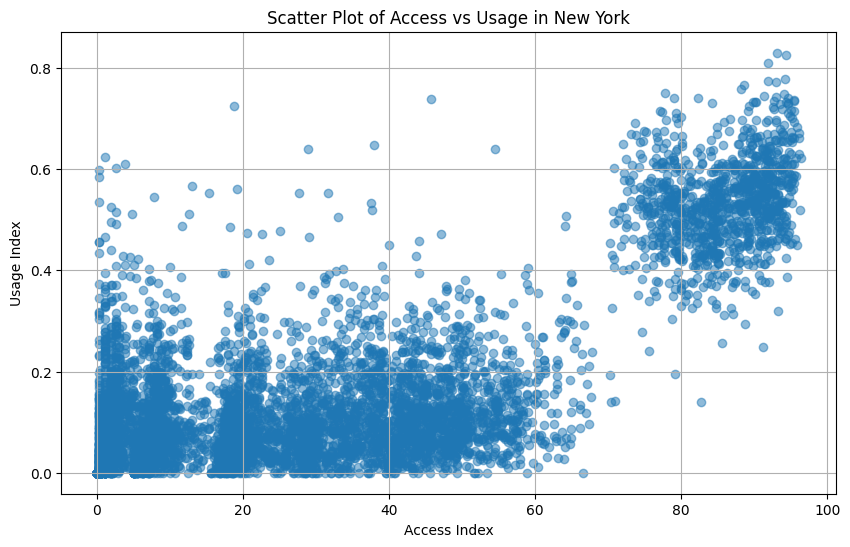

In [8]:
access_index, usage_index, access_df, usage_df = process_city_data('New York')

Phoenix access index: 32.3753
Phoenix usage index (based on demand): 0.1276


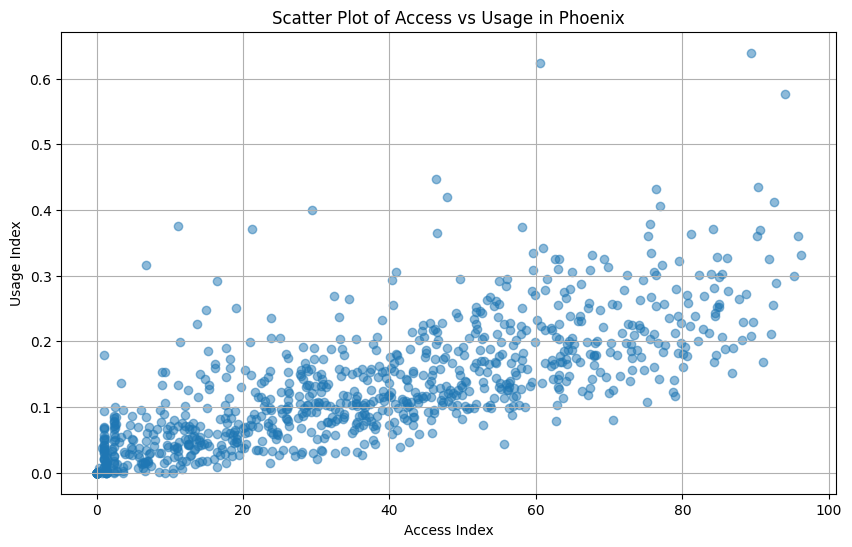

In [9]:
access_index, usage_index, access_df, usage_df = process_city_data('Phoenix')

New York access index: 34.7573
New York usage index (based on demand): 0.2510


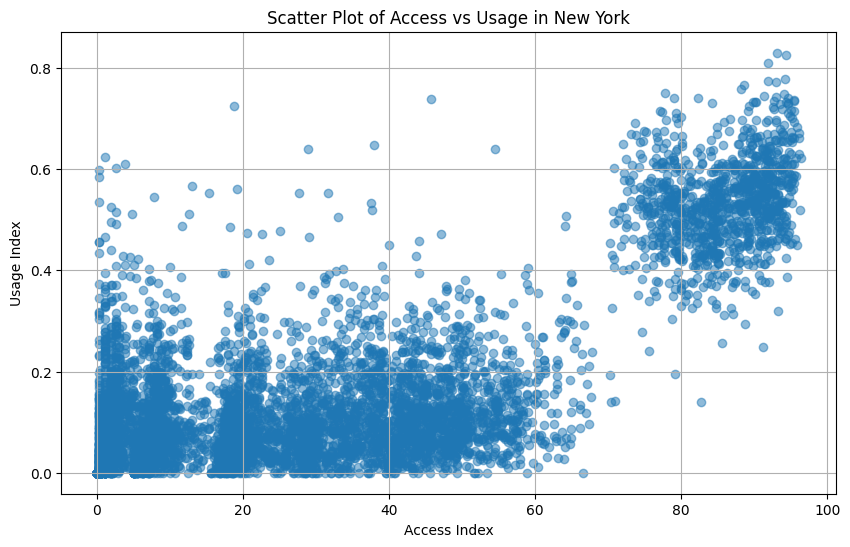

Los Angeles access index: 31.9807
Los Angeles usage index (based on demand): 0.2547


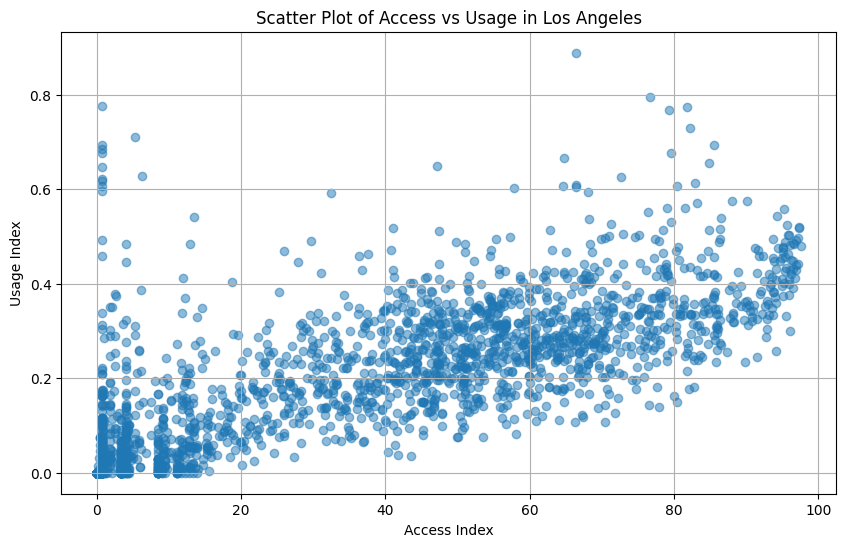

Chicago access index: 50.0569
Chicago usage index (based on demand): 0.2536


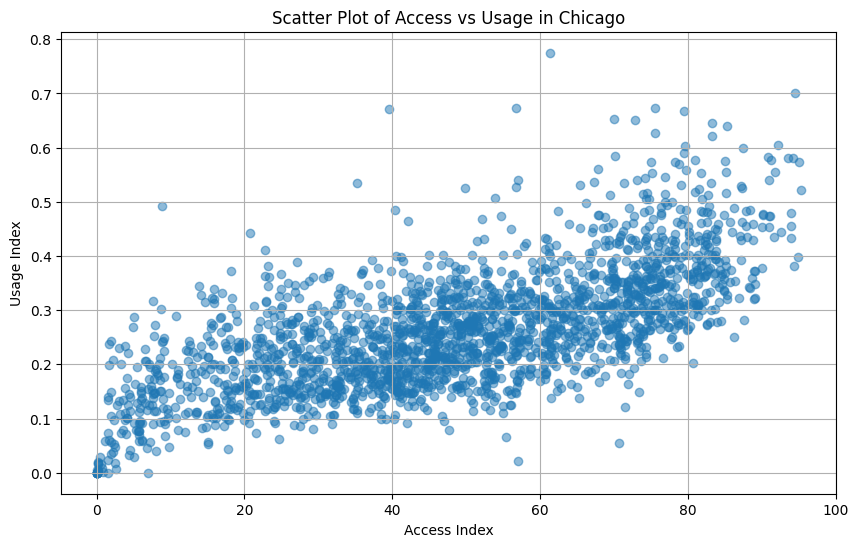

Atlanta access index: 39.0576
Atlanta usage index (based on demand): 0.1776


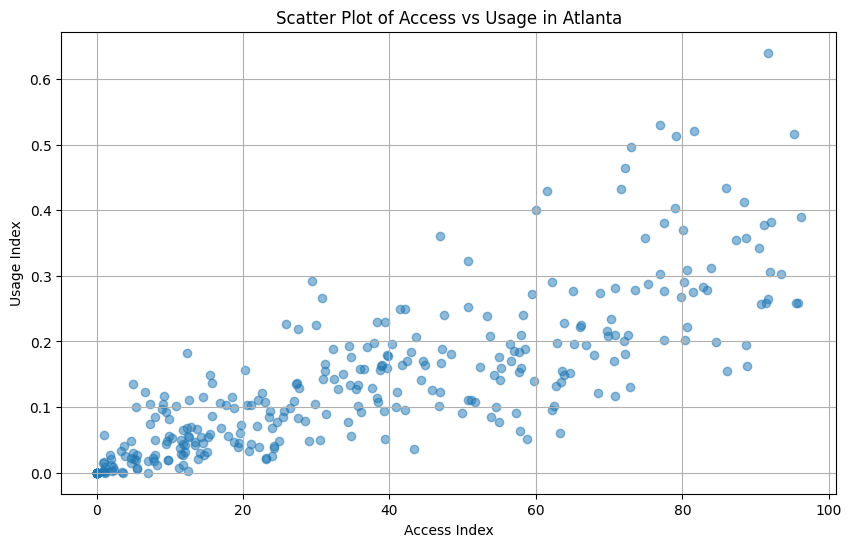

Phoenix access index: 32.3753
Phoenix usage index (based on demand): 0.1276


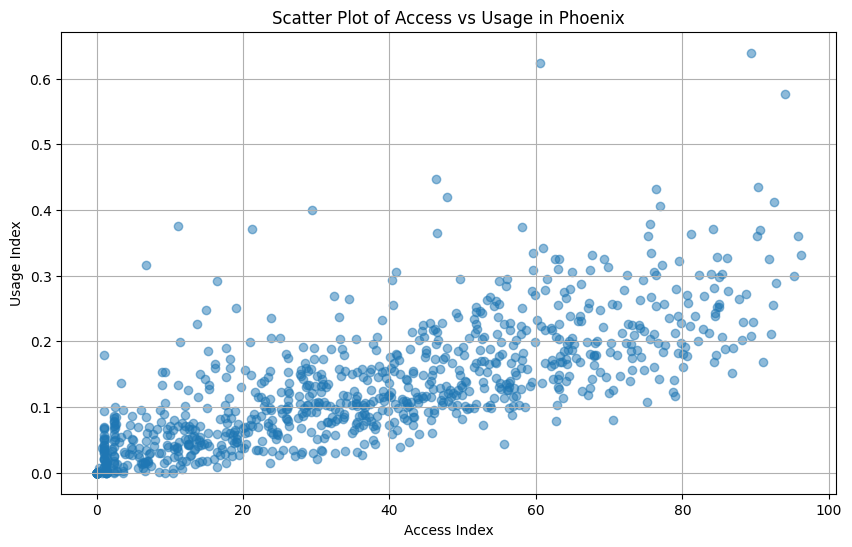

Boston access index: 45.9817
Boston usage index (based on demand): 0.4120


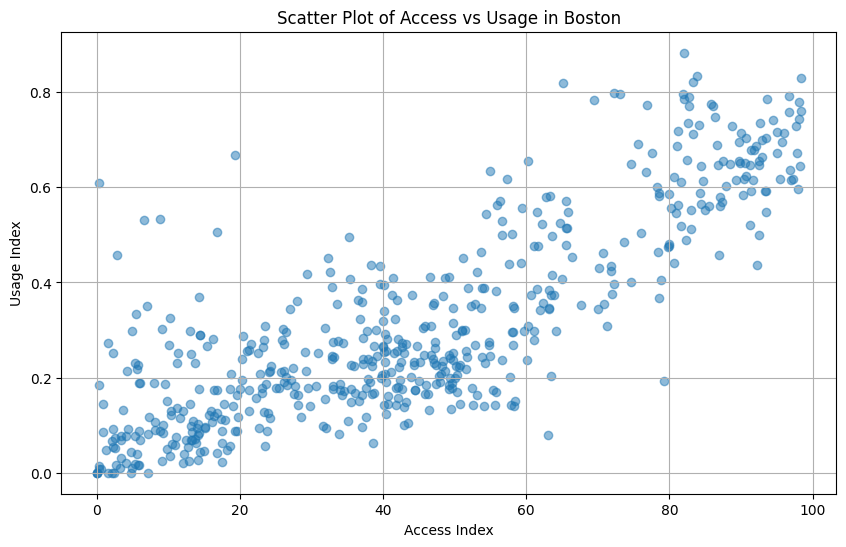

San Francisco access index: 49.4467
San Francisco usage index (based on demand): 0.2938


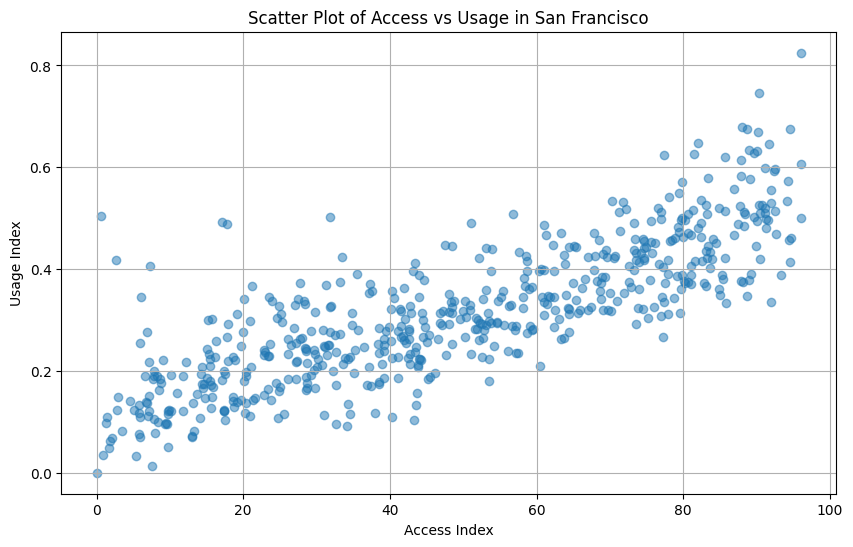

Orlando access index: 23.2284
Orlando usage index (based on demand): 0.1141


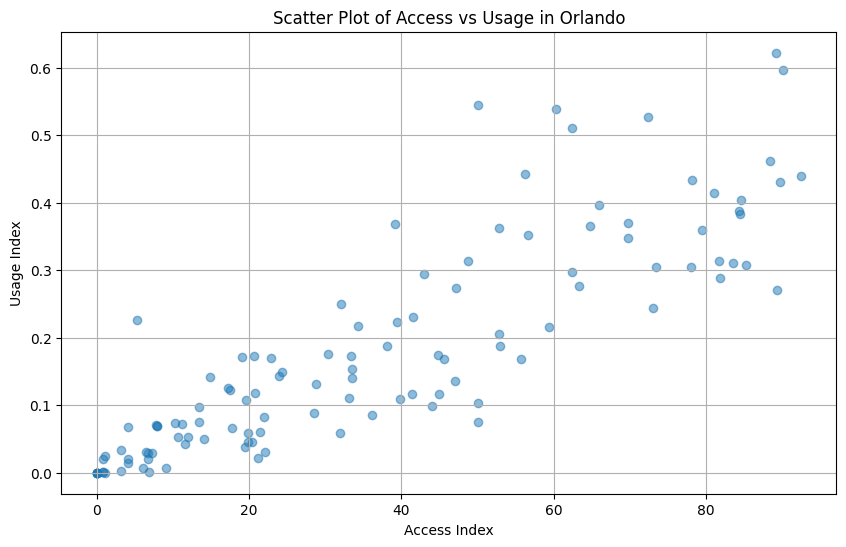

Miami access index: 48.1402
Miami usage index (based on demand): 0.3327


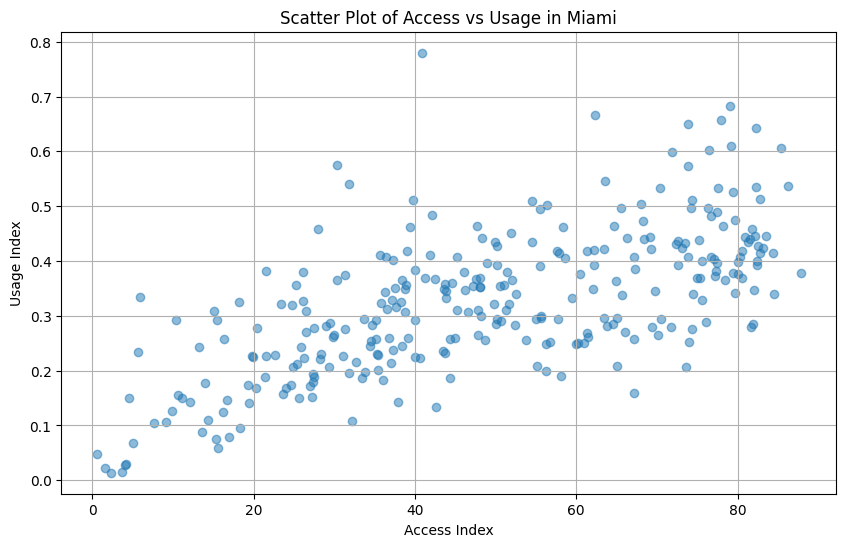

Cleveland access index: 43.4758
Cleveland usage index (based on demand): 0.2845


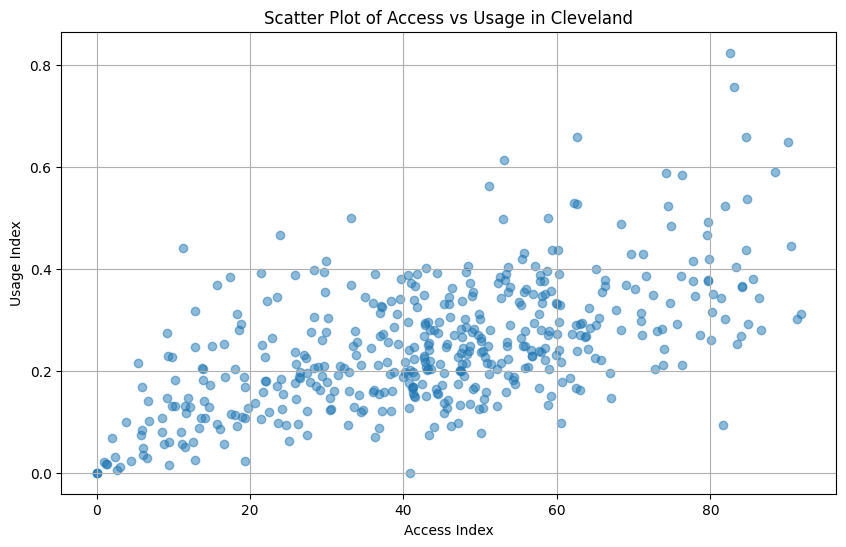

Houston access index: 37.5259
Houston usage index (based on demand): 0.1344


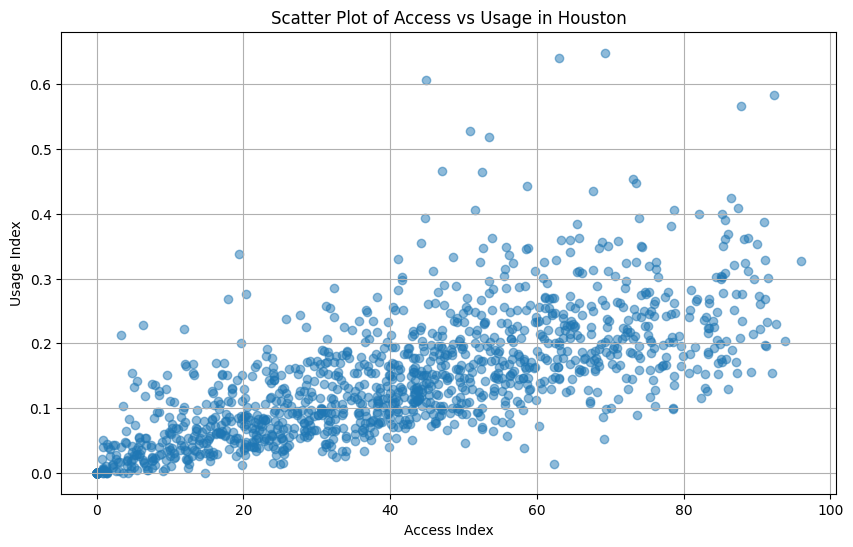

Denver access index: 40.6743
Denver usage index (based on demand): 0.2022


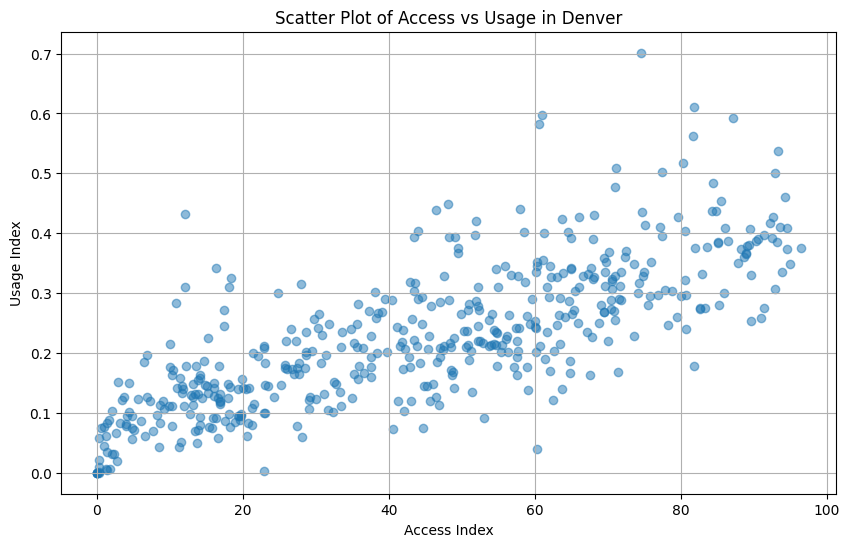

Dallas access index: 36.5746
Dallas usage index (based on demand): 0.1861


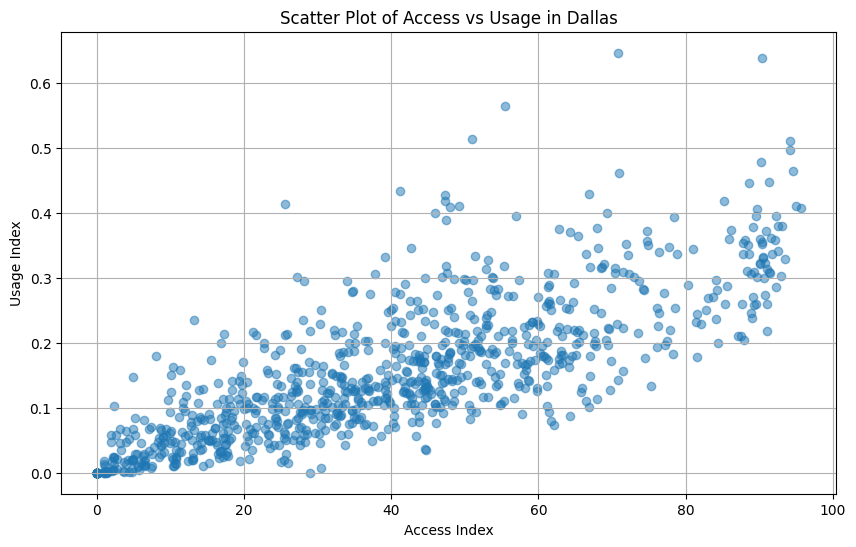

Las Vegas access index: 34.1325
Las Vegas usage index (based on demand): 0.1343


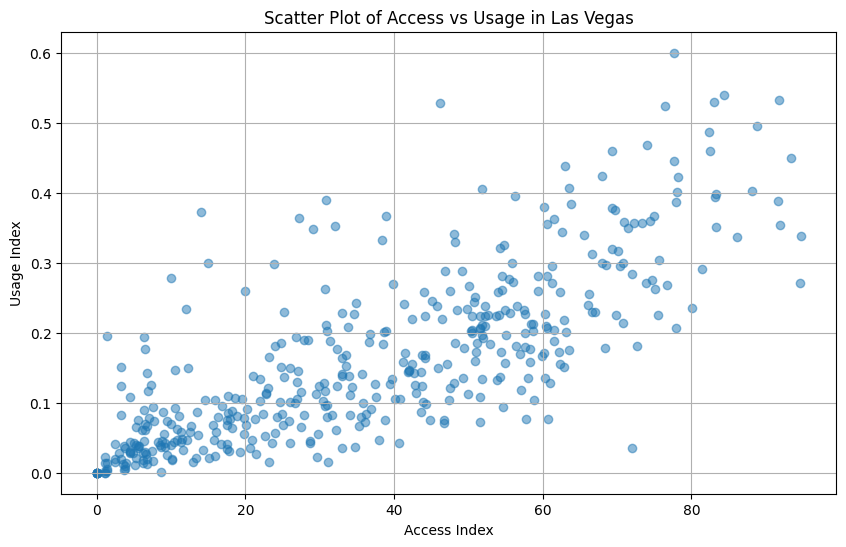

Philadelphia access index: 47.4330
Philadelphia usage index (based on demand): 0.2919


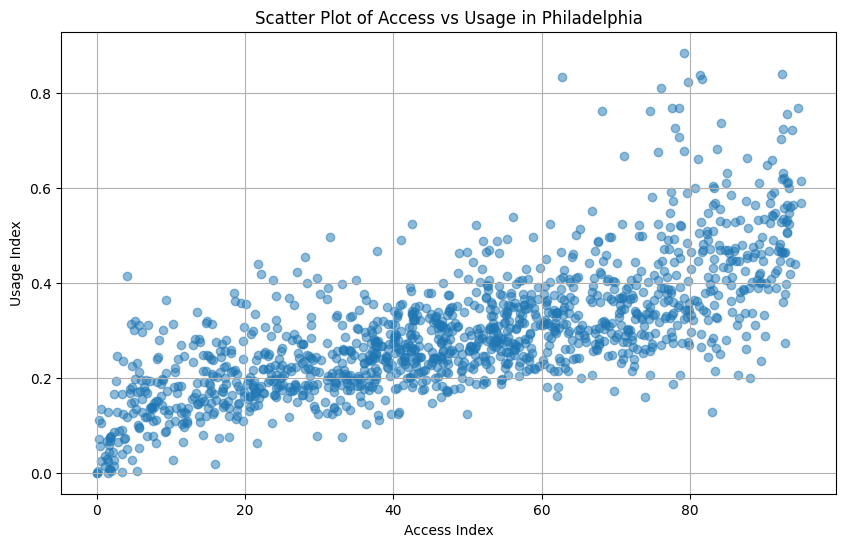

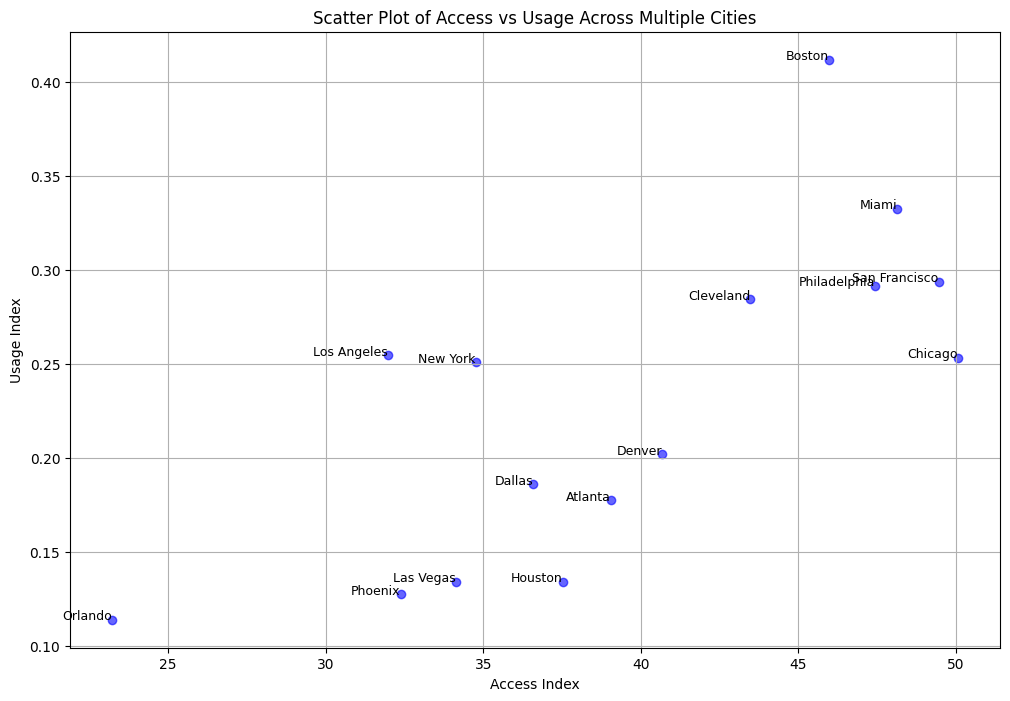

In [10]:
# Example usage:
city_names = ['New York', 'Los Angeles', 'Chicago','Atlanta', 'Phoenix', 'Boston', 'San Francisco', 'Orlando', 'Miami', 'Cleveland', 'Houston', 'Denver', 'Dallas', 'Las Vegas', 'Philadelphia']
access_indices, usage_indices, city_labels = process_multiple_cities(city_names)

In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import json
import os

def calculate_income_category_statistics(city_name):
    # Load city boundaries data
    us_city500_fp = './demo_code/Facility_distribution/500US_Cities_Bond/CityBoundaries.shp' 
    us500city = gpd.read_file(us_city500_fp)
    us_500cities = us500city.to_crs(epsg=4326) # 转换CRS
    
    # Get the boundary of the target city
    city_boundary = us_500cities[us_500cities['NAME'] == city_name].geometry.iloc[0]
    
    # Filter CBGs within the city
    if not isinstance(cbg_geom_df['centroid'].iloc[0], Point):
        cbg_geom_df['centroid'] = cbg_geom_df['centroid'].apply(lambda x: Point(x))
    cbg_in_city = cbg_geom_df[cbg_geom_df['centroid'].apply(lambda x: x.within(city_boundary))]
    cbg_in_city.set_index('CensusBlockGroup', inplace=True) 
    
    # Load population data
    cbg_pop_fp = 'cbg_b01.csv'
    dtype_dic = {'census_block_group': str} 
    cbg_pop_df = pd.read_csv(cbg_pop_fp, dtype=dtype_dic)
    
    cbg_in_city = cbg_in_city.reset_index()
    cbg_in_city['CensusBlockGroup'] = cbg_in_city['CensusBlockGroup'].astype(str)
    cbg_pop_df['census_block_group'] = cbg_pop_df['census_block_group'].astype(str)
    
    # Merge population data with CBGs in the city
    merged_df = pd.merge(cbg_in_city, 
                         cbg_pop_df[['census_block_group', 'B01001e1']], 
                         how='left', 
                         left_on='CensusBlockGroup', 
                         right_on='census_block_group')
    
    merged_df.drop(columns=['census_block_group'], inplace=True)
    merged_df.rename(columns={'B01001e1': 'population'}, inplace=True)
    merged_df.set_index('CensusBlockGroup', inplace=True)
    cbg_in_city = merged_df

    # Load income data and merge with CBGs
    income_df = pd.read_csv('cbg_b19.csv', dtype=dtype_dic)
    cbg_in_city = cbg_in_city.reset_index()
    cbg_in_city['CensusBlockGroup'] = cbg_in_city['CensusBlockGroup'].astype(str)
    merged_df = pd.merge(cbg_in_city, 
                         income_df[['census_block_group', 'B19013e1']], 
                         how='left', 
                         left_on='CensusBlockGroup', 
                         right_on='census_block_group')
    
    merged_df.drop(columns=['census_block_group'], inplace=True)
    merged_df.rename(columns={'B19013e1': 'median_income'}, inplace=True)
    merged_df.set_index('CensusBlockGroup', inplace=True)
    cbg_in_city = merged_df
    
    # Build a dictionary to map CBGs to their centroids
    cbg_to_centroid = {str(index): row['centroid'] for index, row in cbg_in_city.iterrows()}
    
    # Load the SafeGraph data and process it
    filenames = [f'2021{month:02d}_{city_name}.csv' for month in range(1, 13)]
    year2021_data = pd.DataFrame()
    for filename in filenames:
        df = pd.read_csv(filename)
        year2021_data = pd.concat([year2021_data, df], ignore_index=True)

    year2021_data = year2021_data[year2021_data['city'] == city_name]
    year2021_data = year2021_data.dropna(subset=['naics_code'])
    year2021_data = year2021_data.dropna(subset=['poi_cbg'])
    year2021_data = year2021_data.dropna(subset=['visitor_home_cbgs'])

    newdata = year2021_data[['placekey', 'poi_cbg', 'visitor_home_cbgs', 'naics_code', 'longitude', 'latitude']].copy()
    newdata['naics_code'] = newdata['naics_code'].astype(int)

    for index, row in newdata.iterrows():
        visitor_cbgs = json.loads(row['visitor_home_cbgs'])
        filtered_cbgs = {cbg: count for cbg, count in visitor_cbgs.items() if cbg in cbg_to_centroid}
        newdata.at[index, 'visitor_home_cbgs'] = json.dumps(filtered_cbgs)

    newdata['visitor_home_cbgs'] = newdata['visitor_home_cbgs'].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )
    
    # Filter out rows with empty 'visitor_home_cbgs'
    newdata = newdata[newdata['visitor_home_cbgs'].apply(lambda x: bool(x))]
    
    # Group data by placekey and aggregate
    newdata = newdata.groupby('placekey').agg({
        'poi_cbg': 'first',
        'visitor_home_cbgs': lambda x: {k: sum(d.get(k, 0) for d in x if isinstance(d, dict)) for k in set(k for d in x for k in d.keys())},
        'naics_code': 'first', 
        'longitude': 'first',
        'latitude': 'first'
    }).reset_index()

    # Map NAICS codes to POI types
    naics_to_poi_type = {
        '621111': 'Healthcare',
        '621112': 'Healthcare',
        '621410': 'Healthcare',
        '621492': 'Healthcare',
        '621493': 'Healthcare',
        '621498': 'Healthcare',
        '622110': 'Healthcare',
        '446110': 'Drugstores',
        '611110': 'Schools',
        '813110': 'Religious Organizations',
        '722511': 'Restaurants',
        '722513': 'Restaurants',
        '722514': 'Restaurants',
        '722515': 'Restaurants',
        '445110': 'Groceries',
        '445120': 'Groceries',
        '712190': 'Parks',
        '711190': 'Cultural Institutions',
        '713110': 'Cultural Institutions',
        '712110': 'Cultural Institutions',
        '491110': 'Services',
        '522110': 'Services',
        '812111': 'Services',
        '812112': 'Services',
        '812113': 'Services',
        '812320': 'Services'
    }

    def get_poi_type(naics_code):
        return naics_to_poi_type.get(naics_code, 'Other')

    newdata['naics_code'] = newdata['naics_code'].astype(str)
    newdata['poi_type'] = newdata['naics_code'].apply(get_poi_type)

    cbg_in_city = cbg_in_city.set_geometry('geometry').to_crs(epsg=4326)

    newdata['geometry'] = newdata.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    newdata_gdf = gpd.GeoDataFrame(newdata, geometry='geometry', crs='EPSG:4326')

    newdata_gdf = gpd.sjoin(newdata_gdf, cbg_in_city[['geometry']], how='left', predicate='within')

    newdata['poi_cbg'] = newdata_gdf['index_right']
    newdata.drop_duplicates('placekey', inplace=True)
    newdata = newdata[newdata['poi_cbg'].isin(cbg_in_city.index)]
    newdata = pd.merge(newdata, cbg_in_city[['population']], left_on='poi_cbg', right_index=True, how='left')

    # Load isochrones
    cbg_isochrones = gpd.read_file('cbg_isochrones.geojson')
    
    # Income classification
    cbg_in_city = cbg_in_city.dropna(subset=['median_income'])
    income_bins = [-np.inf, 14999, 19999, 24999, 29999, 34999, 39999, 44999, 49999, 59999, 74999, 99999, 124999, 149999, 199999, np.inf]
    income_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    cbg_in_city['income_category'] = pd.cut(cbg_in_city['median_income'], bins=income_bins, labels=income_labels)

    # 初始化结果字典
    income_category_ratios = {label: [] for label in income_labels}

    # 遍历 cbg_isochrones 中的所有 CBG
    for idx, cbg in cbg_isochrones.iterrows():
        target_cbg_id = cbg['cbg_id']
        
        # 过滤出指定城市的CBG
        if target_cbg_id not in cbg_in_city.index:
            continue
        
        target_cbg_polygon = cbg['geometry']
         # 筛选出从目标 CBG 出发的所有记录
        target_rows = newdata[newdata['visitor_home_cbgs'].apply(lambda x: target_cbg_id in x)]
        
        # 初始化计数器
        within_1_25km_count = 0
        total_visitors = 0
        
        # 遍历所有目标行的记录
        for _, row in target_rows.iterrows():
            visitor_count = row['visitor_home_cbgs'][target_cbg_id]  # 从目标 CBG 出发的访客人数
            total_visitors += visitor_count

            destination_point = row['geometry']

            # 判断终点是否在 1.25 公里的范围内
            if destination_point.within(target_cbg_polygon):
                within_1_25km_count += visitor_count
        
        # 计算比例
        within_ratio = within_1_25km_count / total_visitors if total_visitors > 0 else 0
        
        # 将结果存入对应的收入类别
        income_category = cbg_in_city.loc[target_cbg_id, 'income_category']
        income_category_ratios[income_category].append(within_ratio)

    # 计算每个收入类别的平均 15 分钟达成率
    average_ratios = {category: np.mean(ratios) for category, ratios in income_category_ratios.items() if len(ratios) > 0}

    # 转换为 DataFrame 并保存
    average_ratios_df = pd.DataFrame(list(average_ratios.items()), columns=['income_category', 'average_within_ratio'])
    #output_filename = f'average_within_ratios_by_income_category_{city_name}.csv'
    #average_ratios_df.to_csv(output_filename, index=False)
    #print(f"Saved results to {output_filename}")
    return average_ratios_df

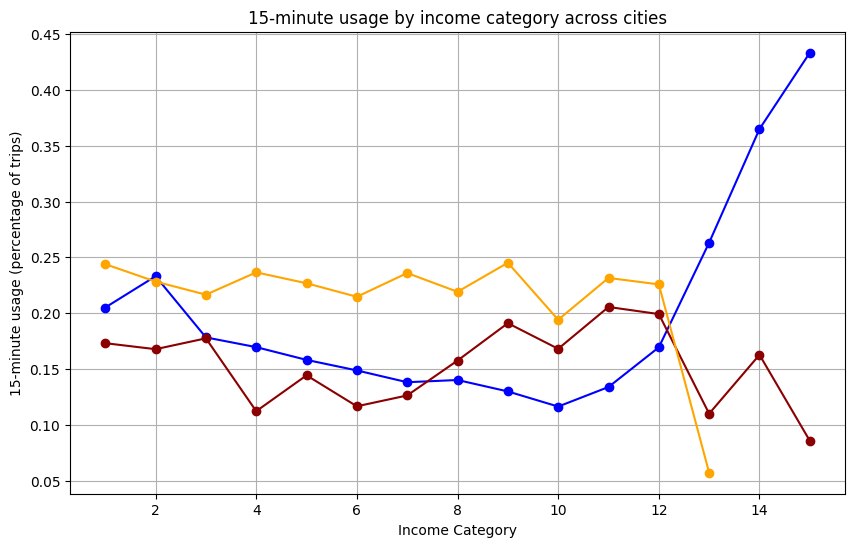

In [6]:
# Ensure that the data is sorted by income category for consistent plotting
New_York_ratio_sorted = New_York_ratio.sort_values('income_category')
Atlanta_ratio_sorted = Atlanta_ratio.sort_values('income_category')
Detroit_ratio_sorted = Detroit_ratio.sort_values('income_category')

# Plotting
plt.figure(figsize=(10, 6))

# Plot each city's line
plt.plot(New_York_ratio_sorted['income_category'], 
         New_York_ratio_sorted['average_within_ratio'], 
         marker='o', label='New York', color='blue')

plt.plot(Atlanta_ratio_sorted['income_category'], 
         Atlanta_ratio_sorted['average_within_ratio'], 
         marker='o', label='Atlanta', color='darkred')

plt.plot(Detroit_ratio_sorted['income_category'], 
         Detroit_ratio_sorted['average_within_ratio'], 
         marker='o', label='Detroit', color='orange')

# Add labels and title
plt.xlabel('Income Category')
plt.ylabel('15-minute usage (percentage of trips)')
plt.title('15-minute usage by income category across cities')
plt.grid(True)


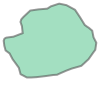

In [7]:
import requests
import folium
from shapely.geometry import shape, Point
import geopandas as gpd

# 定义OpenRouteService API的基础URL
ORS_BASE_URL = "https://api.openrouteservice.org/v2/isochrones/foot-walking"

# 你的API Key
API_KEY = '5b3ce3597851110001cf62481dabad9f66cb4d5a96fb83b191a52f16'

# 定义一个函数来获取等高线polygon
def get_isochrone_polygon(centroid, distance=1250):
    # 请求的body数据
    body = {
        "locations": [[centroid.x, centroid.y]],
        "range": [distance],  # 范围设置为1.25公里
        "range_type": "distance",
        "units": "m",
        "attributes": ["area", "reachfactor", "total_pop"]
    }

    # 请求头部信息
    headers = {
        'Authorization': API_KEY,
        'Content-Type': 'application/json'
    }

    # 发送POST请求到OpenRouteService
    response = requests.post(ORS_BASE_URL, json=body, headers=headers)
    
    # 检查响应状态码
    if response.status_code != 200:
        raise Exception(f"Error fetching isochrone: {response.status_code} - {response.text}")
    
    # 解析响应中的GeoJSON数据
    isochrone_geojson = response.json()
    
    # 提取生成的Polygon或MultiPolygon
    isochrone_geometry = shape(isochrone_geojson['features'][0]['geometry'])
    return isochrone_geometry

cbg_id = '360050175002'  # 示例CBG ID
centroid = cbg_to_centroid[cbg_id]
polygon_360050175002 = get_isochrone_polygon(centroid,2500)
polygon_1_25km=get_isochrone_polygon(centroid)
polygon_360050175002

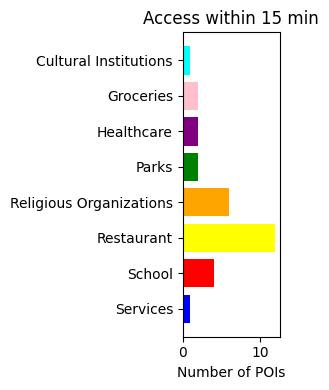

In [24]:
import matplotlib.pyplot as plt

# 假设这些是你统计出的 1.25 公里内的 POI 数量
poi_counts = {
    'Services': 1,
    'School': 4,
    'Restaurant': 12,
    'Religious Organizations': 6,
    'Parks': 2,
    'Healthcare': 2,
    'Groceries': 2,
    'Cultural Institutions': 1
}

# 使用 matplotlib 绘制柱状图
fig, ax = plt.subplots(figsize=(3, 4))
ax.barh(list(poi_counts.keys()), list(poi_counts.values()), color=list(poi_colors.values()))
ax.set_xlabel('Number of POIs')
ax.set_title('Access within 15 min')
plt.tight_layout()

# 保存柱状图为图片
#plt.savefig('poi_barchart.png', bbox_inches='tight', transparent=True)
plt.close()
fig

In [30]:
import folium
from folium.plugins import BeautifyIcon
import geopandas as gpd

# Define colors for different POI types
poi_colors = {
    'Services': '#0000FF',  # Blue
    'Schools': '#FF0000',    # Red
    'Restaurants': '#FFFF00', # Yellow
    'Religious Organizations': '#FFA500',  # Orange
    'Parks': '#008000',      # Green
    'Healthcare': '#800080', # Purple
    'Groceries': '#FFC0CB',  # Pink
    'Cultural Institutions': '#00FFFF', # Cyan
    'Drugstores': '#8B4513',   # Brown
    'Other': '#808080'       # Gray
}

# Initialize map centered around the CBG centroid
cbg_id = '360050175002'
centroid = cbg_to_centroid[cbg_id]
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

# Plot the 1.25km isochrone polygon
folium.GeoJson(polygon_1_25km, style_function=lambda x: {'color': 'blue'}).add_to(m)

# Plot the CBG centroid
folium.Marker([centroid.y, centroid.x], 
              icon=folium.Icon(color='red', icon='info-sign')).add_to(m)

# Filter POIs within 2.5km range
poi_in_2_5km = newdata[newdata['geometry'].apply(lambda x: x.within(polygon_360050175002))]

# Add POIs to the map
for idx, poi in poi_in_2_5km.iterrows():
    poi_type = poi['poi_type']
    poi_color = poi_colors.get(poi_type, 'black')
    
    folium.Marker(
        location=[poi.geometry.y, poi.geometry.x],
        icon=BeautifyIcon(
            icon_shape='circle-dot',
            border_color=poi_color,
            border_width=5,
            text_color=poi_color,
            inner_icon_style='font-size:12px;'  # Adjust the font size of the inner icon
        ),
        popup=f"{poi_type}: {poi['placekey']}"
    ).add_to(m)

# Add a custom legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: 300px; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
<b>Legend</b><br>
<i style="background: #0000FF; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Services<br>
<i style="background: #FF0000; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Schools<br>
<i style="background: #FFFF00; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Restaurants<br>
<i style="background: #FFA500; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Religious Organizations<br>
<i style="background: #008000; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Parks<br>
<i style="background: #800080; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Healthcare<br>
<i style="background: #FFC0CB; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Groceries<br>
<i style="background: #00FFFF; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Cultural Institutions<br>
<i style="background: #8B4513; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Drugstores<br>
<i style="background: #808080; width: 18px; height: 18px; float: left; margin-right: 5px;"></i> Other<br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
m


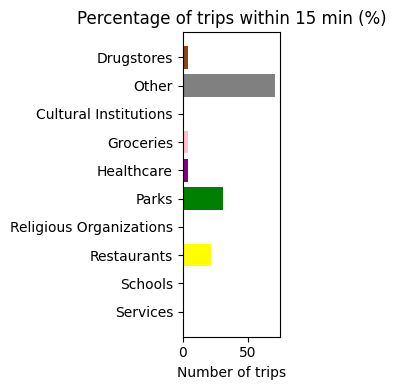

In [33]:
import folium
from folium.plugins import BeautifyIcon
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import base64

# 获取目标 CBG 的信息
cbg_id = '360050175002'
centroid = cbg_to_centroid[cbg_id]

# 初始化地图
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=15)

# 添加1.25km的范围
folium.GeoJson(polygon_1_25km, style_function=lambda x: {'color': 'blue', 'weight': 2, 'fill': False}).add_to(m)

# 定义颜色字典
poi_colors = {
    'Services': '#0000FF',  # Blue
    'Schools': '#FF0000',    # Red
    'Restaurants': '#FFFF00', # Yellow
    'Religious Organizations': '#FFA500',  # Orange
    'Parks': '#008000',      # Green
    'Healthcare': '#800080', # Purple
    'Groceries': '#FFC0CB',  # Pink
    'Cultural Institutions': '#00FFFF', # Cyan
    'Other': '#808080',       # Gray
    'Drugstores': '#8B4513'   # Brown
}

# 初始化图例的数据结构
poi_counts = {k: 0 for k in poi_colors.keys()}
within_count = 0
outside_count = 0
folium.GeoJson(polygon_1_25km, style_function=lambda x: {'color': 'blue'}).add_to(m)
# 过滤出2.5公里范围内的POI
poi_in_2_5km = newdata[newdata['geometry'].apply(lambda x: x.within(polygon_360050175002))]

# 遍历从目标 CBG 出发的所有记录
for idx, poi in poi_in_2_5km.iterrows():
    visitor_cbgs = poi['visitor_home_cbgs']
    poi_type = poi['poi_type']
    destination_point = poi['geometry']
    visitors = visitor_cbgs.get(cbg_id, 0)
    
    if visitors > 0:
        # 累计该类型的 POI 数量
        poi_counts[poi_type] += visitors

        # 判断终点是否在 1.25 公里的范围内
        if destination_point.within(polygon_1_25km):
            within_count += visitors
        else:
            outside_count += visitors

        # 绘制路线
        folium.PolyLine(locations=[[centroid.y, centroid.x], [destination_point.y, destination_point.x]],
                        color=poi_colors.get(poi_type, 'black'),
                        weight=2.5).add_to(m)
    
            # 在目的地添加颜色标记
        folium.Marker(
            location=[destination_point.y, destination_point.x],
            icon=BeautifyIcon(
                icon_shape='circle-dot',
                border_color=poi_colors.get(poi_type, 'black'),
                border_width=5,
                text_color=poi_colors.get(poi_type, 'black')
            ),
            popup=f"{poi_type}: {poi['placekey']}"
        ).add_to(m)

# 添加图例的柱状图
fig, ax = plt.subplots(figsize=(3, 4))
ax.barh(list(poi_counts.keys()), list(poi_counts.values()), color=list(poi_colors.values()))
ax.set_xlabel('Number of trips')
ax.set_title('Percentage of trips within 15 min (%)')
plt.tight_layout()

# 保存柱状图为图片
plt.savefig('poi_trip_chart.png', bbox_inches='tight', transparent=True)
plt.close()

# 将柱状图保存为 base64 编码的字符串
with open("poi_trip_chart.png", "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode()

# 添加自定义图例（包含柱状图）
legend_html = f'''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 220px; height: 350px; 
            background-color: white; z-index:9999; font-size:14px;
            padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="width:200px;">
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))

# 保存最终地图
m


In [45]:
import folium
from folium import features
import geopandas as gpd

# 定义目标 CBG 的 ID
target_cbg_id = '360610084002'

# 找到目标 CBG 的多边形 (1.25km 范围)
target_cbg_polygon = cbg_isochrones.loc[cbg_isochrones['cbg_id'] == target_cbg_id, 'geometry'].iloc[0]

# 创建一个地图对象，初始中心为目标 CBG 的几何中心
centroid = target_cbg_polygon.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=14)

# 在地图上绘制 1.25km 的范围
folium.GeoJson(target_cbg_polygon, style_function=lambda x: {'fillColor': 'blue', 'color': 'blue', 'weight': 2, 'fillOpacity': 0.1}).add_to(m)

# 找出 newdata 中所有从目标 CBG 出发的人
target_rows = newdata[newdata['visitor_home_cbgs'].apply(lambda x: target_cbg_id in x)]

# 在地图上标记这些人到达的终点
for idx, row in target_rows.iterrows():
    destination_point = row['geometry']
    folium.Marker(
        location=[destination_point.y, destination_point.x],
        popup=f"POI: {row['placekey']}, Type: {row['poi_type']}",
        icon=folium.Icon(color='red', icon='map-marker')
    ).add_to(m)

# 将地图显示在当前 Jupyter Notebook 环境中
m

In [57]:
# 筛选出从目标 CBG 出发的所有记录
target_cbg_id = '360470404002'
target_rows = newdata[newdata['visitor_home_cbgs'].apply(lambda x: target_cbg_id in x)]

# 初始化计数器
within_1_25km_count = 0
outside_1_25km_count = 0
total_visitors = 0

# 遍历所有目标行的记录
for idx, row in target_rows.iterrows():
    visitor_count = row['visitor_home_cbgs'][target_cbg_id]  # 从目标 CBG 出发的访客人数
    total_visitors += visitor_count

    destination_point = row['geometry']
    
    # 判断终点是否在 1.25 公里的范围内
    if destination_point.within(target_cbg_polygon):
        within_1_25km_count += visitor_count
    else:
        outside_1_25km_count += visitor_count

# 计算比例
within_ratio = within_1_25km_count / total_visitors if total_visitors > 0 else 0
outside_ratio = outside_1_25km_count / total_visitors if total_visitors > 0 else 0

# 输出结果
print(f"Total visitors from CBG {target_cbg_id}: {total_visitors}")
print(f"Visitors within 1.25km: {within_1_25km_count} ({within_ratio:.2%})")
print(f"Visitors outside 1.25km: {outside_1_25km_count} ({outside_ratio:.2%})")

Total visitors from CBG 360470404002: 1558
Visitors within 1.25km: 226 (14.51%)
Visitors outside 1.25km: 1332 (85.49%)


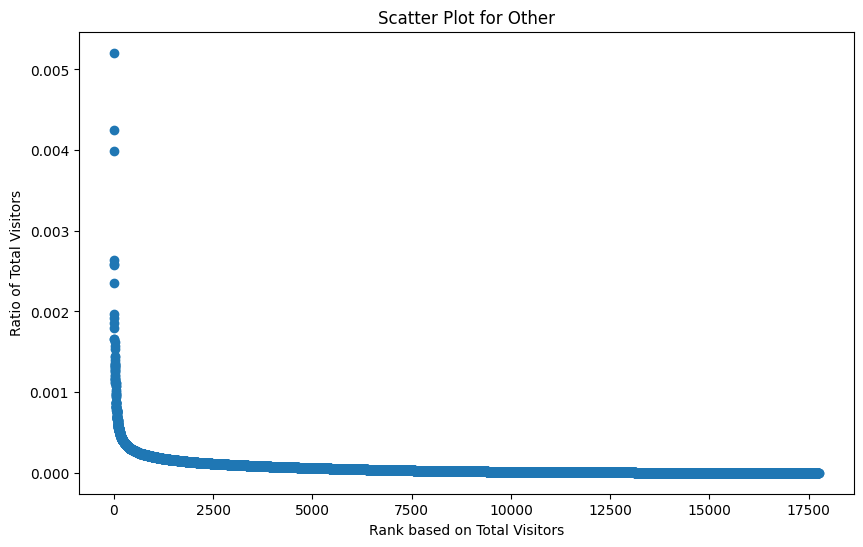

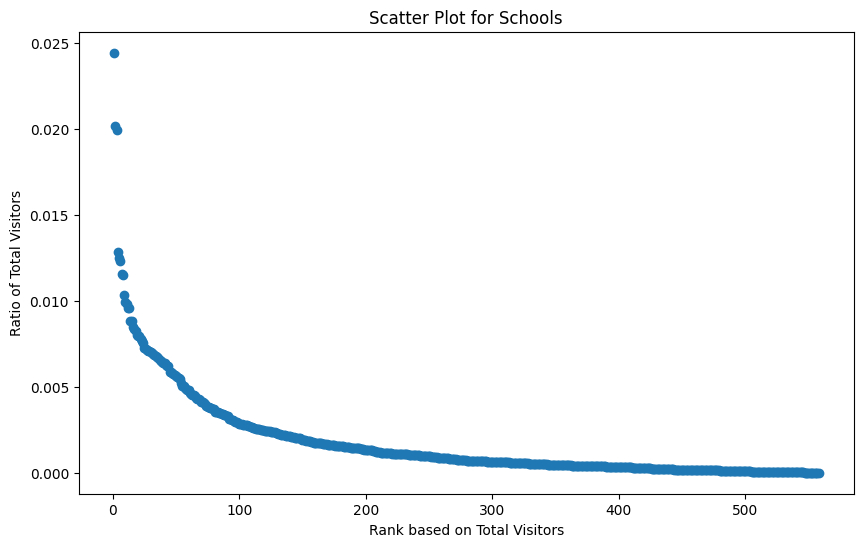

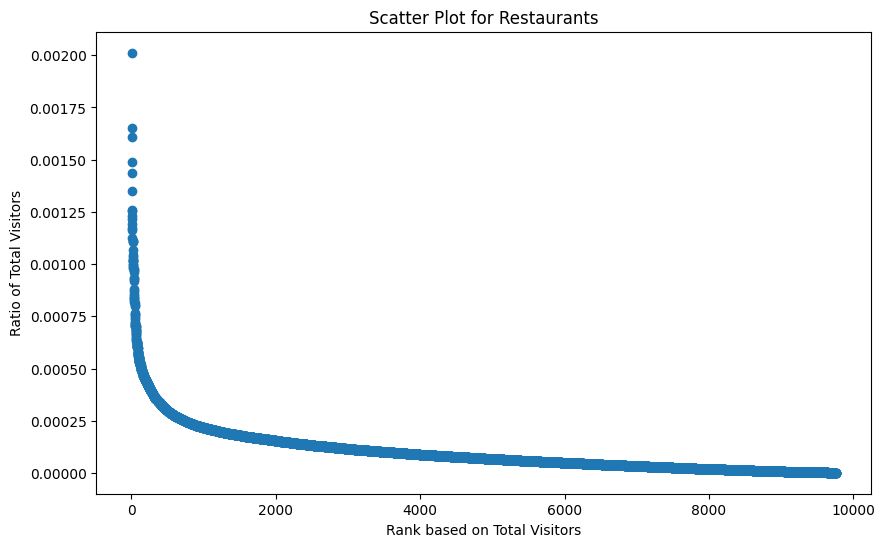

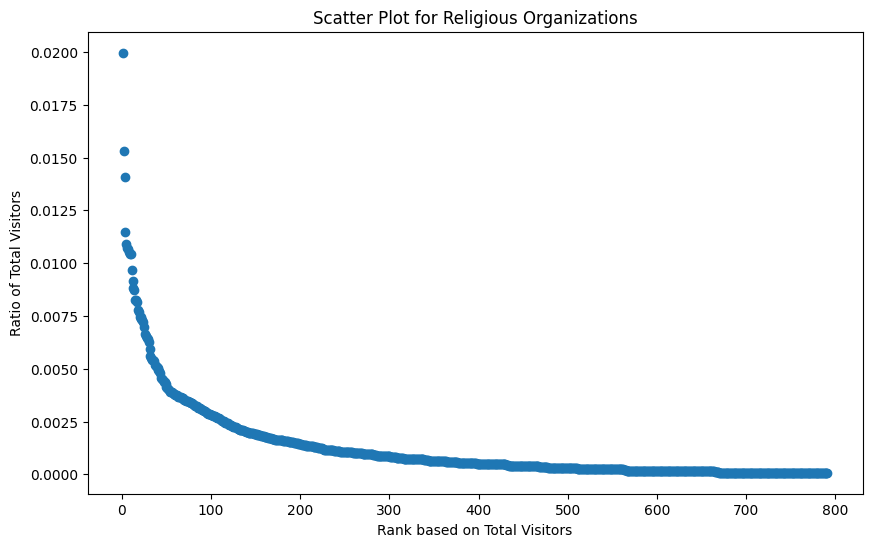

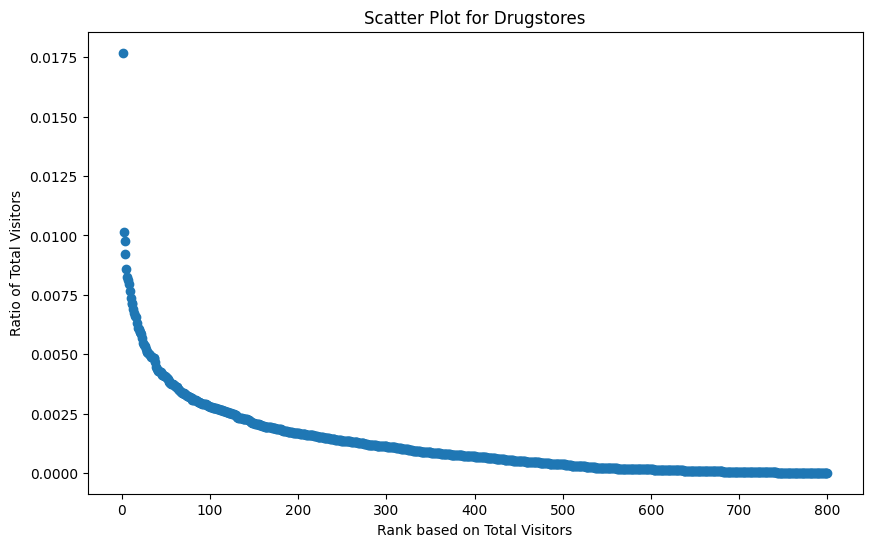

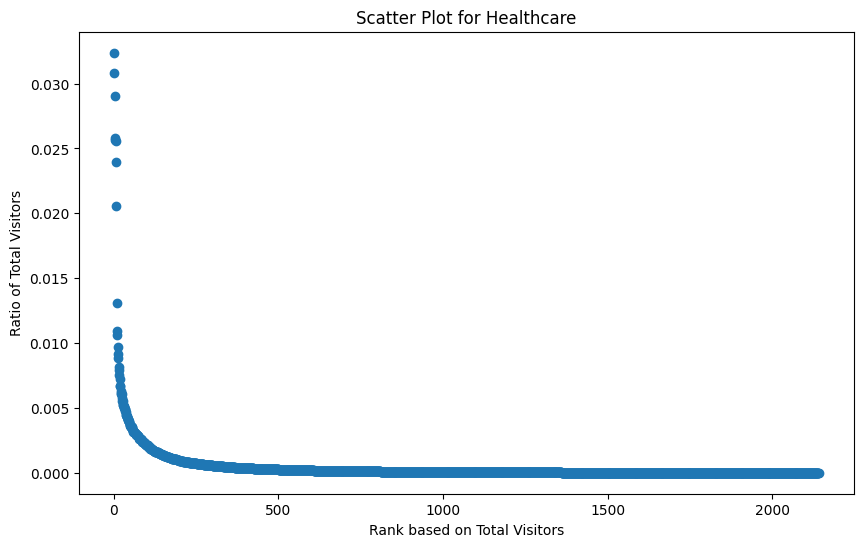

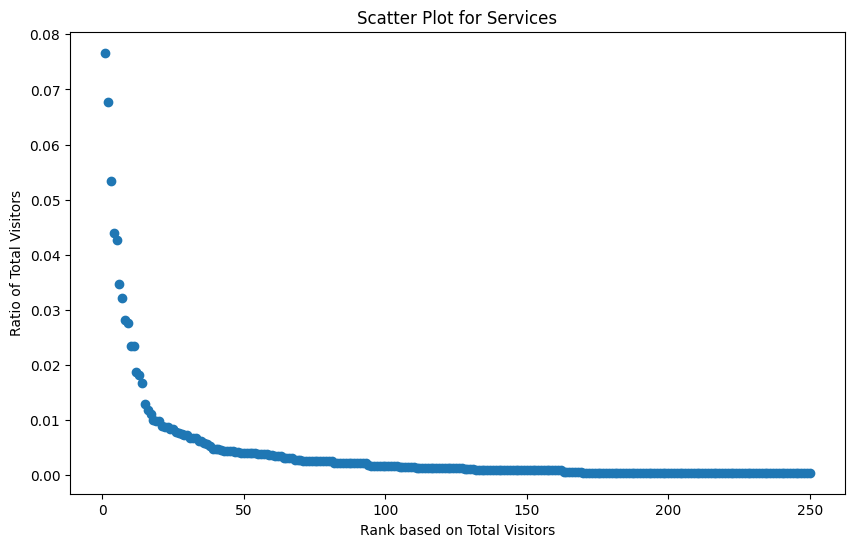

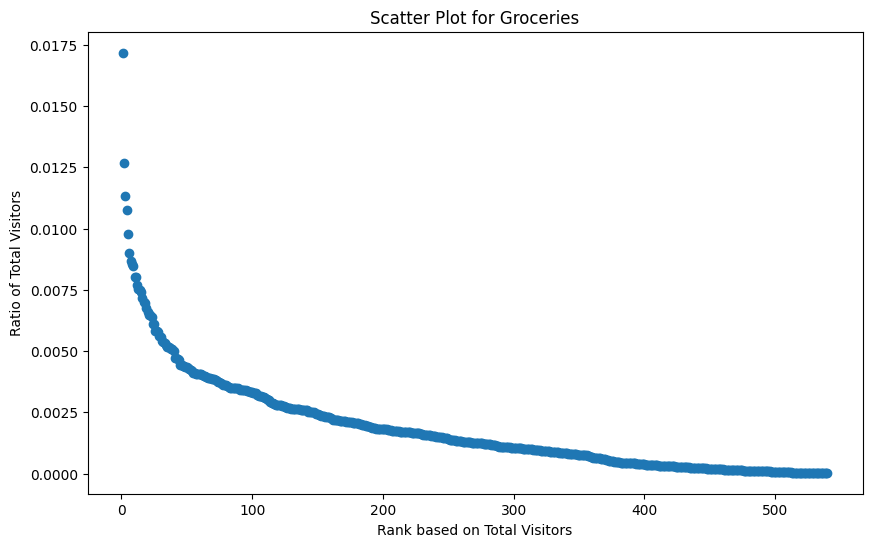

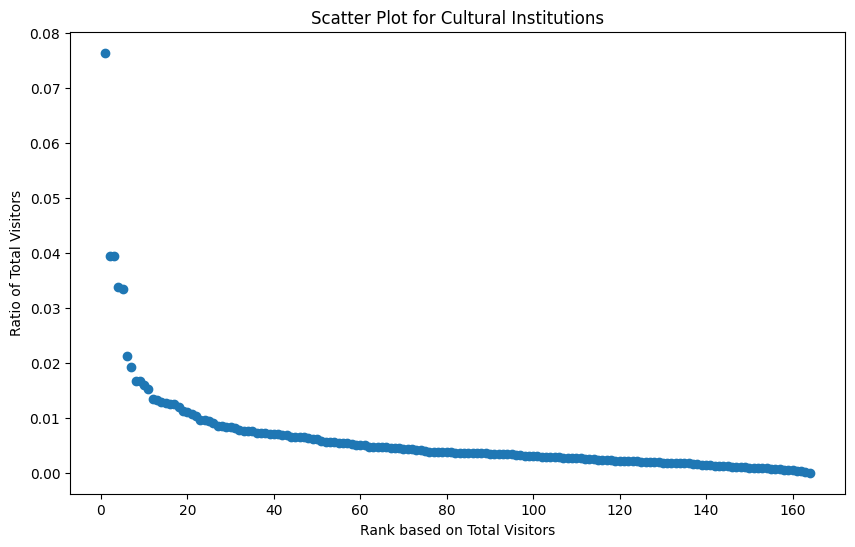

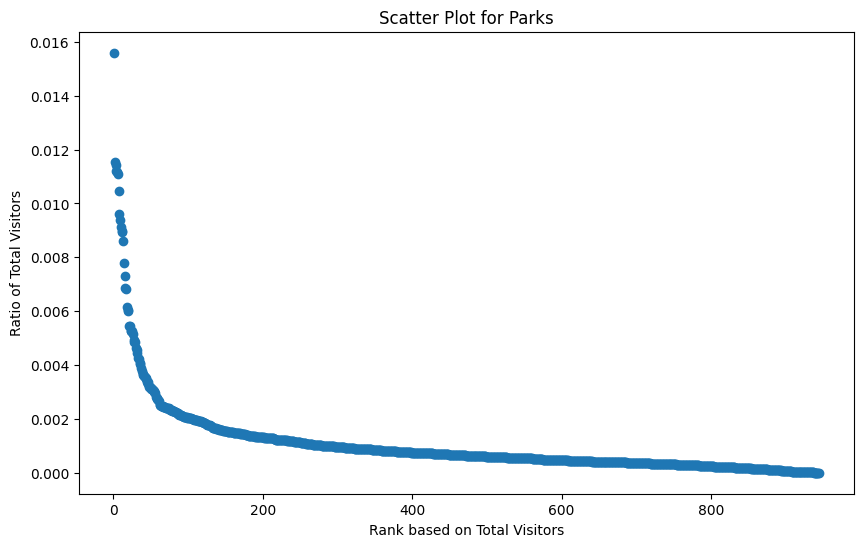

In [15]:
newdata['total_visitors'] = newdata['visitor_home_cbgs'].apply(lambda x: sum(x.values()))

# 获取每个poi_type的唯一值
poi_types = newdata['poi_type'].unique()

# 为每个poi_type绘制散点图
for poi in poi_types:
    poi_data = newdata[newdata['poi_type'] == poi]
    
    # 根据总访客数降序排列并为其排名
    poi_data = poi_data.sort_values(by='total_visitors', ascending=False).reset_index(drop=True)
    poi_data['rank'] = poi_data.index + 1
    
    # 计算访客比例
    poi_data['visitor_ratio'] = poi_data['total_visitors'] / poi_data['total_visitors'].sum()
    
    # 绘制散点图
    plt.figure(figsize=(10, 6))
    plt.scatter(poi_data['rank'], poi_data['visitor_ratio'])
    plt.title(f'Scatter Plot for {poi}')
    plt.xlabel('Rank based on Total Visitors')
    plt.ylabel('Ratio of Total Visitors')
    plt.show()

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


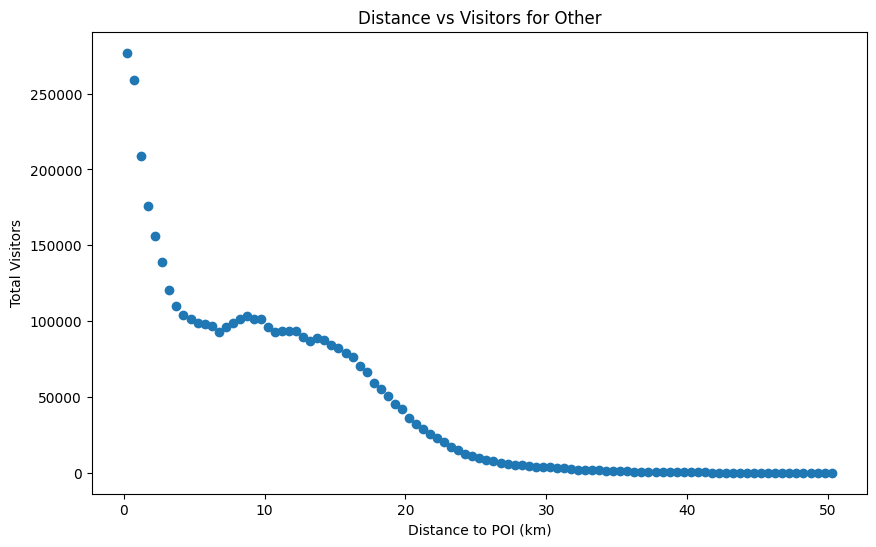

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


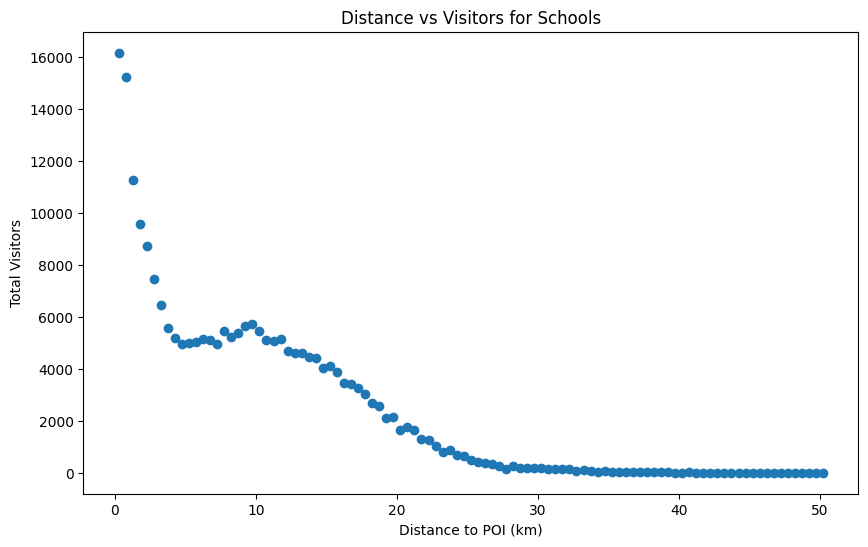

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


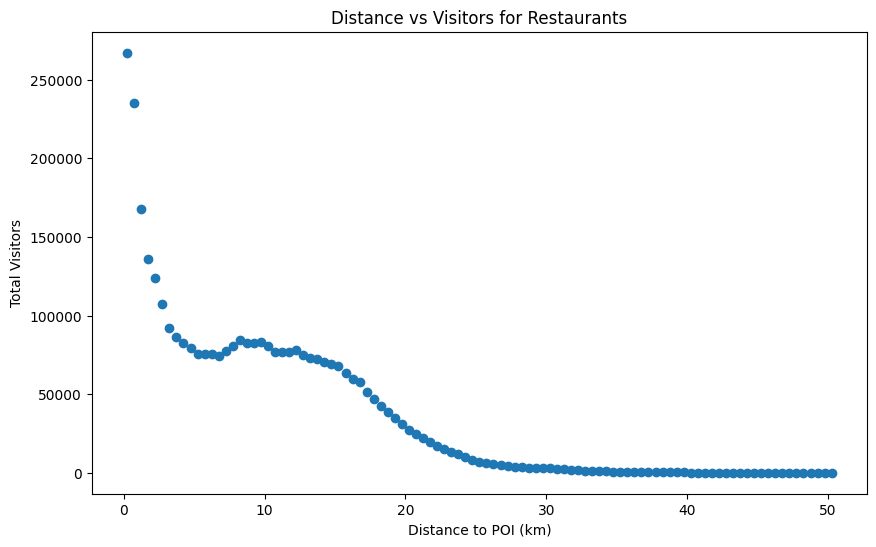

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


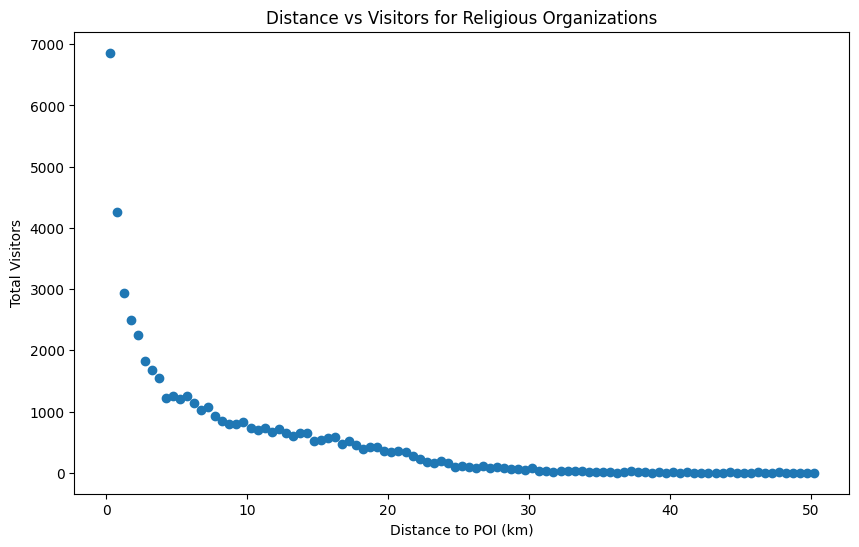

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


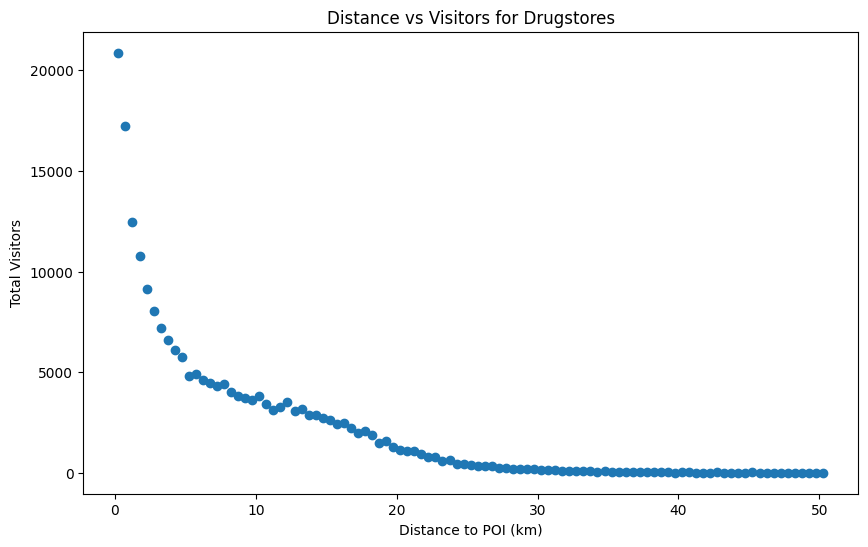

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


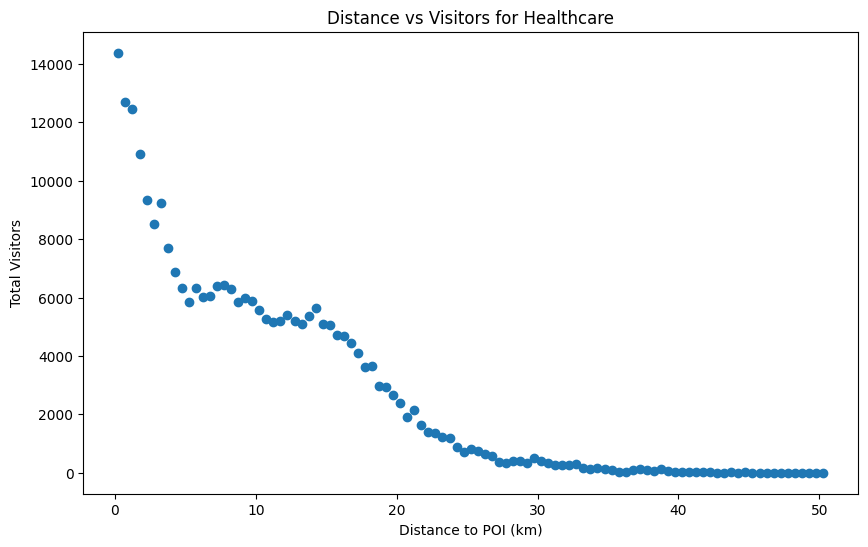

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


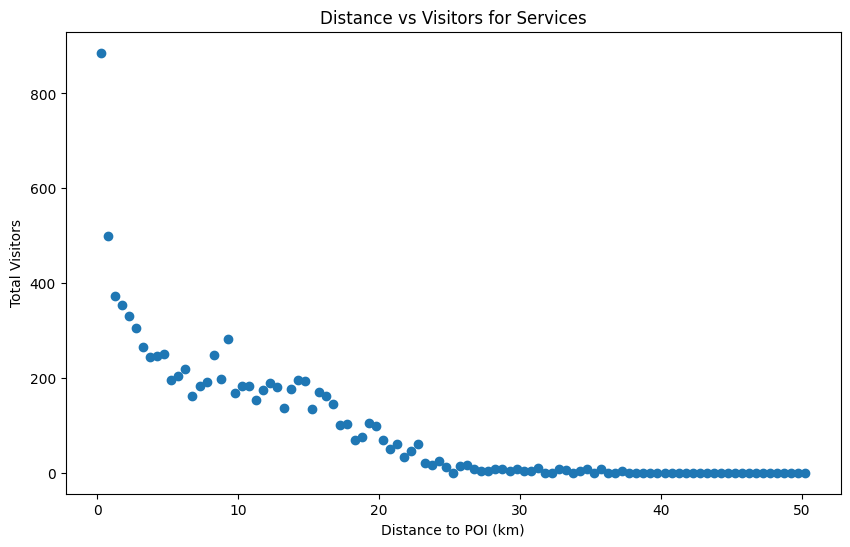

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


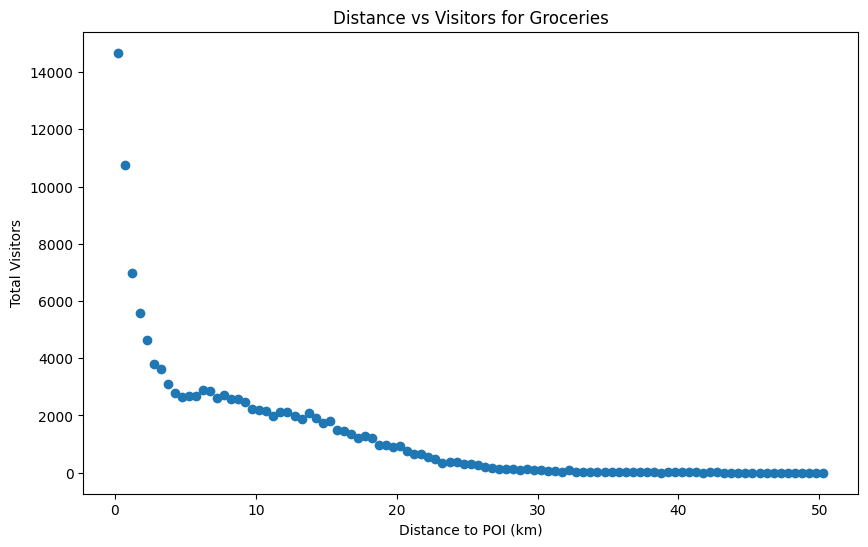

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


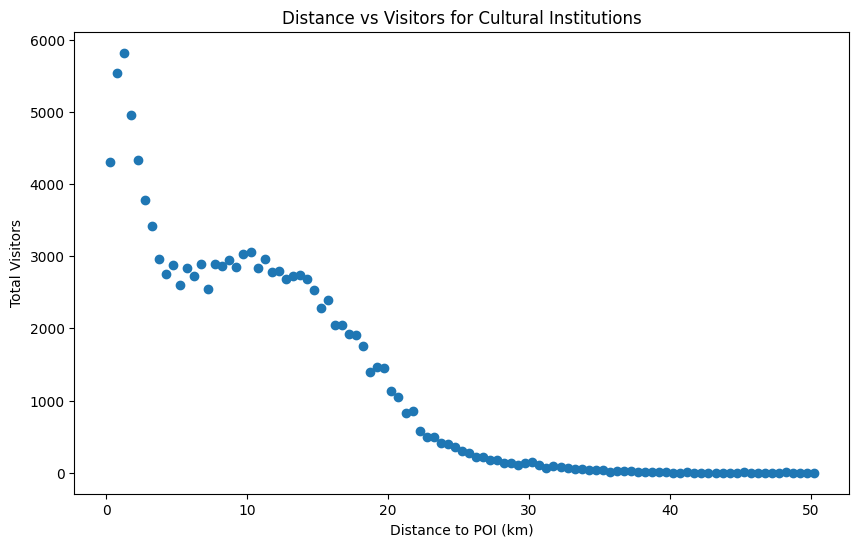

C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2803367538.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()


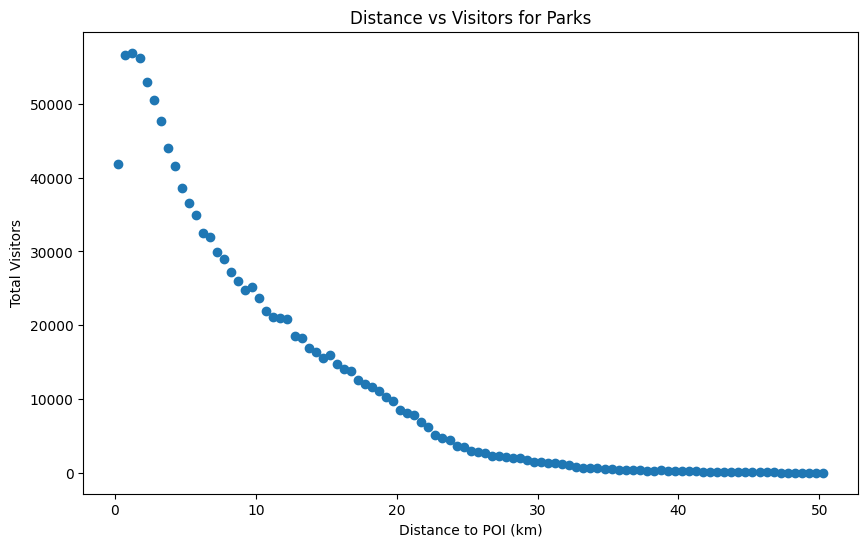

In [16]:
def haversine_distance(point1, point2):
    return great_circle((point1.y, point1.x), (point2.y, point2.x)).kilometers

poi_type_data = {}
for index, row in newdata.iterrows():
    poi_type = row['poi_type']
    poi_location = Point(row['longitude'], row['latitude'])
    visitor_cbgs = row['visitor_home_cbgs']
    
    if poi_type not in poi_type_data:
        poi_type_data[poi_type] = []

    for cbg, count in visitor_cbgs.items():
        if cbg in cbg_to_centroid:
            visitor_location = cbg_to_centroid[cbg]
            distance = haversine_distance(poi_location, visitor_location)
            poi_type_data[poi_type].append((distance, count))


for poi_type, data in poi_type_data.items():
    distance_df = pd.DataFrame(data, columns=['Distance', 'Count'])
    distance_df['Distance_Bin'] = pd.cut(distance_df['Distance'], bins=np.arange(0, 51, 0.5))
    aggregated_data = distance_df.groupby('Distance_Bin')['Count'].sum().reset_index()
    aggregated_data['Distance_Center'] = aggregated_data['Distance_Bin'].apply(lambda x: x.mid)
    plt.figure(figsize=(10, 6))
    plt.scatter(aggregated_data['Distance_Center'], aggregated_data['Count'])
    plt.title(f'Distance vs Visitors for {poi_type}')
    plt.xlabel('Distance to POI (km)')
    plt.ylabel('Total Visitors')
    plt.show()

Fitted parameters: a = 6868.976157740541, beta = 0.6336491744299496


C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2870453857.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = groceries_df.groupby('Distance_Bin')['Count'].sum().reset_index()


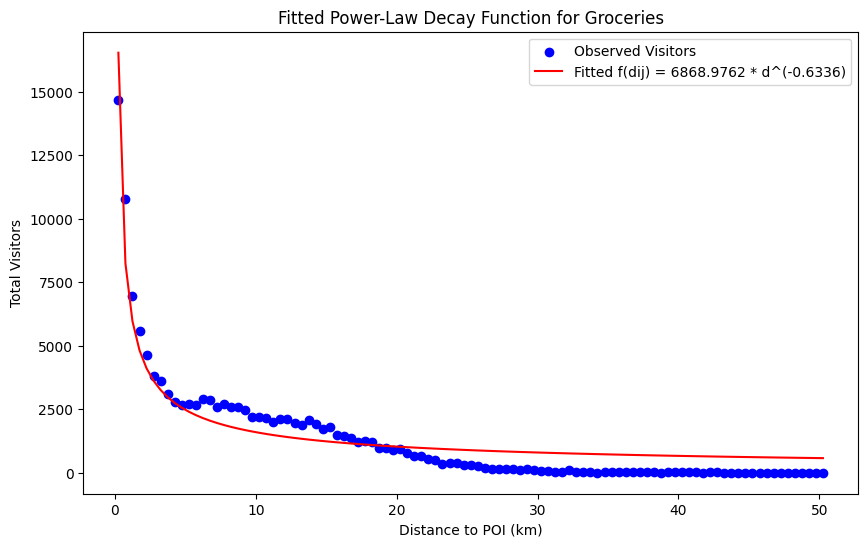

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def distance_decay_power_law(d, a, beta):
    return a * (d ** -beta)

groceries_data = poi_type_data['Groceries']
groceries_df = pd.DataFrame(groceries_data, columns=['Distance', 'Count'])
groceries_df['Distance_Bin'] = pd.cut(groceries_df['Distance'], bins=np.arange(0, 51, 0.5))

aggregated_data = groceries_df.groupby('Distance_Bin')['Count'].sum().reset_index()
aggregated_data['Distance_Center'] = aggregated_data['Distance_Bin'].apply(lambda x: x.mid)

distances = aggregated_data['Distance_Center'].astype(float).values
total_visitors = aggregated_data['Count'].values

popt, _ = curve_fit(distance_decay_power_law, distances, total_visitors, p0=[1, 1])
a, beta = popt
print(f"Fitted parameters: a = {a}, beta = {beta}")

fitted_curve = distance_decay_power_law(distances, a, beta)

plt.figure(figsize=(10, 6))
plt.scatter(distances, total_visitors, label='Observed Visitors', color='blue')
plt.plot(distances, fitted_curve, label=f'Fitted f(dij) = {a:.4f} * d^(-{beta:.4f})', color='red')
plt.title('Fitted Power-Law Decay Function for Groceries')
plt.xlabel('Distance to POI (km)')
plt.ylabel('Total Visitors')
plt.legend()
plt.show()


C:\Users\jack\AppData\Local\Temp\ipykernel_23612\2959250226.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_data = groceries_df.groupby('Distance_Bin')['Count'].sum().reset_index()


Fitted parameters: a = 1241.673105253982, beta = -335549652.62012666


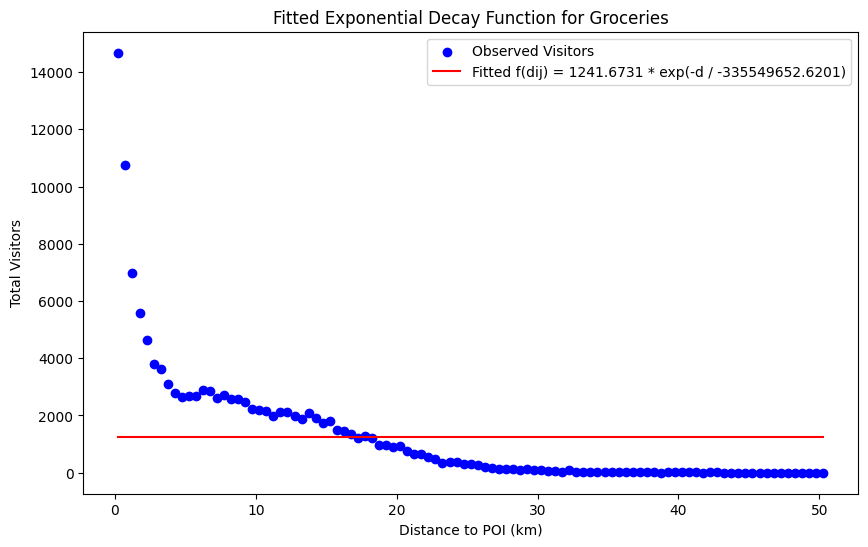

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def distance_decay_exp(d, a, beta):
    return a * np.exp(-d / beta)

groceries_data = poi_type_data['Groceries']
groceries_df = pd.DataFrame(groceries_data, columns=['Distance', 'Count'])
groceries_df['Distance_Bin'] = pd.cut(groceries_df['Distance'], bins=np.arange(0, 51, 0.5))

aggregated_data = groceries_df.groupby('Distance_Bin')['Count'].sum().reset_index()
aggregated_data['Distance_Center'] = aggregated_data['Distance_Bin'].apply(lambda x: x.mid)
distances = aggregated_data['Distance_Center'].astype(float).values
total_visitors = aggregated_data['Count'].values

popt, _ = curve_fit(distance_decay_exp, distances, total_visitors, p0=[1, 1])
a, beta = popt
print(f"Fitted parameters: a = {a}, beta = {beta}")
fitted_curve = distance_decay_exp(distances, a, beta)

plt.figure(figsize=(10, 6))
plt.scatter(distances, total_visitors, label='Observed Visitors', color='blue')
plt.plot(distances, fitted_curve, label=f'Fitted f(dij) = {a:.4f} * exp(-d / {beta:.4f})', color='red')
plt.title('Fitted Exponential Decay Function for Groceries')
plt.xlabel('Distance to POI (km)')
plt.ylabel('Total Visitors')
plt.legend()
plt.show()

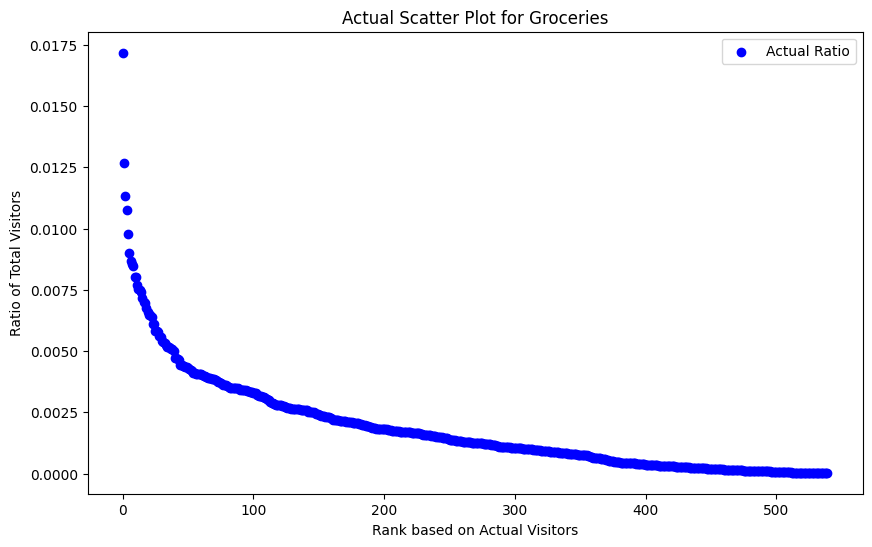

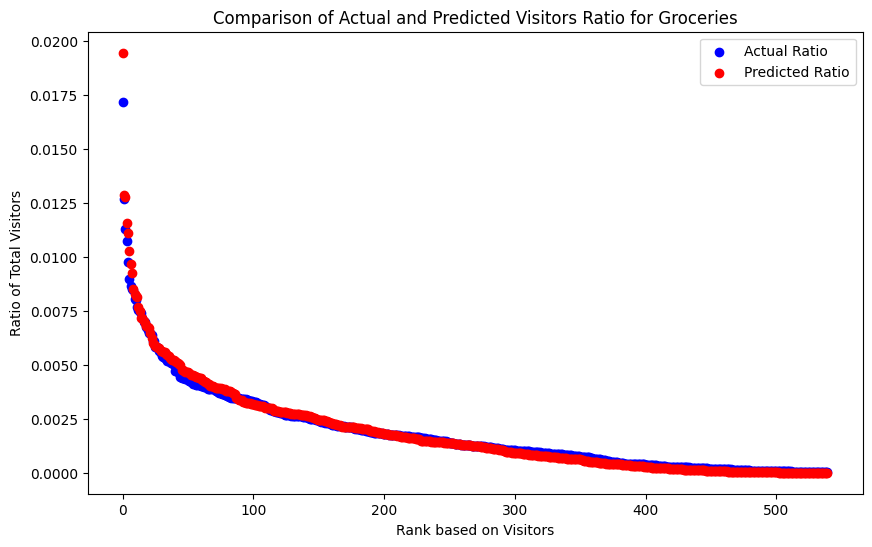

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.optimize import curve_fit

def haversine_distance(point1, point2):
    return great_circle((point1.y, point1.x), (point2.y, point2.x)).kilometers

def distance_decay_power_law(d, a, beta):
    return a * (d ** -beta)

a = 6868.9762
beta = 0.6336

def calculate_predicted_visitors(row):
    total_predicted_visitors = 0
    poi_location = Point(row['longitude'], row['latitude'])
    visitor_cbgs = row['visitor_home_cbgs']
    poi_population = row['population'] 
    
    for cbg, count in visitor_cbgs.items():
        if cbg in cbg_to_centroid:
            visitor_location = cbg_to_centroid[cbg]
            distance = haversine_distance(poi_location, visitor_location)
            decay_value = distance_decay_power_law(distance, a, beta)
            total_predicted_visitors += poi_population * decay_value
    
    return total_predicted_visitors

groceries_data = newdata[newdata['poi_type'] == 'Groceries'].copy()
groceries_data.loc[:, 'predicted_visitors'] = groceries_data.apply(calculate_predicted_visitors, axis=1)
groceries_data.loc[:, 'actual_visitors_ratio'] = groceries_data['total_visitors'] / groceries_data['total_visitors'].sum()
groceries_data.loc[:, 'predicted_visitors_ratio'] = groceries_data['predicted_visitors'] / groceries_data['predicted_visitors'].sum()


groceries_sorted_actual = groceries_data.sort_values(by='actual_visitors_ratio', ascending=False).reset_index(drop=True)
groceries_sorted_predicted = groceries_data.sort_values(by='predicted_visitors_ratio', ascending=False).reset_index(drop=True)

# actual
plt.figure(figsize=(10, 6))
plt.scatter(groceries_sorted_actual.index, groceries_sorted_actual['actual_visitors_ratio'], label='Actual Ratio', color='blue')
plt.title('Actual Scatter Plot for Groceries')
plt.xlabel('Rank based on Actual Visitors')
plt.ylabel('Ratio of Total Visitors')
plt.legend()
plt.show()

# predicted
plt.figure(figsize=(10, 6))
plt.scatter(groceries_sorted_actual.index, groceries_sorted_actual['actual_visitors_ratio'], label='Actual Ratio', color='blue')
plt.scatter(groceries_sorted_predicted.index, groceries_sorted_predicted['predicted_visitors_ratio'], label='Predicted Ratio', color='red')
plt.title('Comparison of Actual and Predicted Visitors Ratio for Groceries')
plt.xlabel('Rank based on Visitors')
plt.ylabel('Ratio of Total Visitors')
plt.legend()
plt.show()



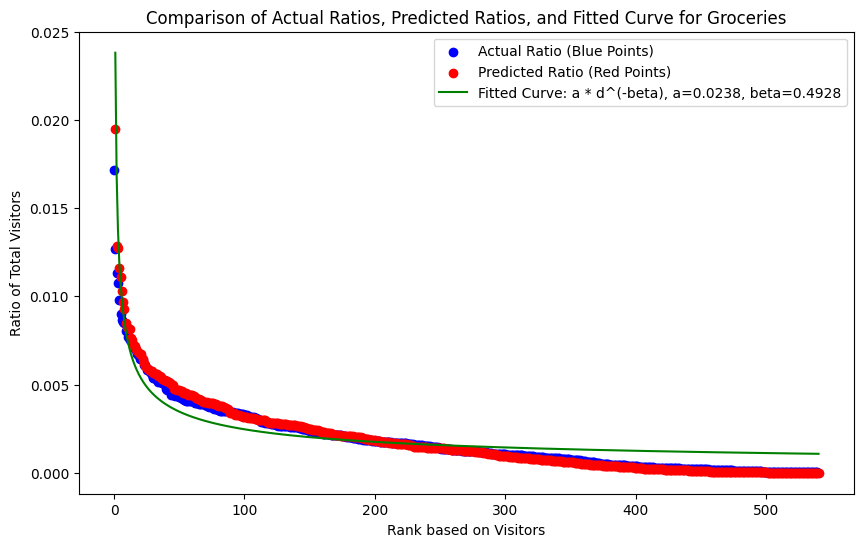

R^2 value for the fitted curve with respect to the actual ratios: 0.8415


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def distance_decay_power_law(d, a, beta):
    return a * (d ** -beta)

predicted_ratios = groceries_sorted_predicted['predicted_visitors_ratio'].values
ranks = np.arange(1, len(predicted_ratios) + 1)
popt, _ = curve_fit(distance_decay_power_law, ranks, predicted_ratios)
a_fit, beta_fit = popt

fitted_curve = distance_decay_power_law(ranks, a_fit, beta_fit)

plt.figure(figsize=(10, 6))
plt.scatter(groceries_sorted_actual.index, groceries_sorted_actual['actual_visitors_ratio'], label='Actual Ratio (Blue Points)', color='blue')
plt.scatter(ranks, predicted_ratios, label='Predicted Ratio (Red Points)', color='red')
plt.plot(ranks, fitted_curve, label=f'Fitted Curve: a * d^(-beta), a={a_fit:.4f}, beta={beta_fit:.4f}', color='green')
plt.title('Comparison of Actual Ratios, Predicted Ratios, and Fitted Curve for Groceries')
plt.xlabel('Rank based on Visitors')
plt.ylabel('Ratio of Total Visitors')
plt.legend()
plt.show()
actual_ratios = groceries_sorted_actual['actual_visitors_ratio'].values
r2 = r2_score(actual_ratios, fitted_curve)
print(f'R^2 value for the fitted curve with respect to the actual ratios: {r2:.4f}')


In [ ]:
#difference
comparison_df = groceries_sorted_actual[['placekey', 'actual_visitors_ratio']].merge(
    groceries_sorted_predicted[['placekey', 'predicted_visitors_ratio']],
    on='placekey',
    how='inner'
)

comparison_df['difference'] = comparison_df['actual_visitors_ratio'] - comparison_df['predicted_visitors_ratio']
comparison_df=comparison_df.sort_values(by='difference', ascending=False)
comparison_df



placekey  actual_visitors_ratio  predicted_visitors_ratio  \
0    223-222@627-wc9-nnq               0.017176                  0.009679   
13   zzw-223@627-s8j-whq               0.007472                  0.002738   
49   zzy-223@627-rwq-q9f               0.004338                  0.000000   
22   22h-222@627-s8r-jy9               0.006379                  0.002124   
53   zzy-225@627-rwq-snq               0.004186                  0.000000   
..                   ...                    ...                       ...   
64   223-222@627-s6n-7h5               0.003955                  0.008280   
113  zzw-222@627-s4v-zj9               0.002903                  0.008155   
27   228-222@627-s6n-7t9               0.005789                  0.011104   
35   226-222@627-s8j-2zf               0.005159                  0.011590   
4    227-222@627-s4n-49z               0.009784                  0.019471   

     difference  
0      0.007497  
13     0.004734  
49     0.004338  
22     0.004255  
53     0.004186  
..          ...  
64    -0.004325  
113   -0.005252  
27    -0.005315  
35    -0.006430  
4     -0.009687  

[540 rows x 4 columns]

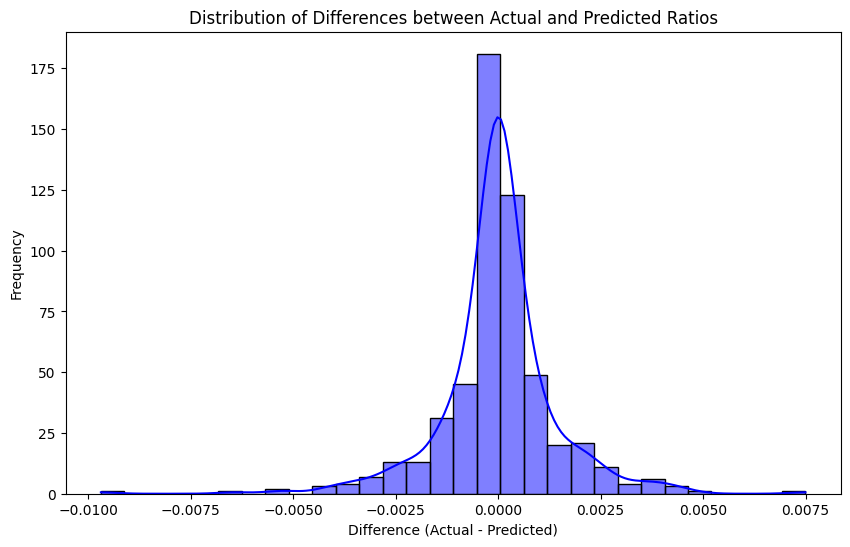

: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制 difference 的分布图
plt.figure(figsize=(10, 6))
sns.histplot(comparison_df['difference'], bins=30, kde=True, color='blue')
plt.title('Distribution of Differences between Actual and Predicted Ratios')
plt.xlabel('Difference (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
groceries_sorted_actual['actual_rank'] = groceries_sorted_actual.index + 1
groceries_sorted_predicted['predicted_rank'] = groceries_sorted_predicted.index + 1

comparison_df = groceries_sorted_actual[['placekey', 'actual_rank']].merge(
    groceries_sorted_predicted[['placekey', 'predicted_rank']],
    on='placekey',
    how='inner'
)
comparison_df['rank_difference'] = comparison_df['actual_rank'] - comparison_df['predicted_rank']
large_rank_diff = comparison_df.sort_values(by='rank_difference', key=abs, ascending=False)
large_rank_diff

placekey  actual_rank  predicted_rank  rank_difference
49   zzy-223@627-rwq-q9f           50             537             -487
60   zzy-222@627-rwq-qpv           61             534             -473
53   zzy-225@627-rwq-snq           54             520             -466
111  zzy-222@627-rwq-qj9          112             535             -423
115  zzy-222@627-rww-6x5          116             527             -411
..                   ...          ...             ...              ...
158  zzw-222@627-s4t-389          159             158                1
127  22b-222@627-s4v-33q          128             127                1
403  22v-222@627-s8j-bp9          404             405               -1
2    226-222@627-s6f-4d9            3               3                0
1    22c-222@627-s8h-vj9            2               2                0

[540 rows x 4 columns]

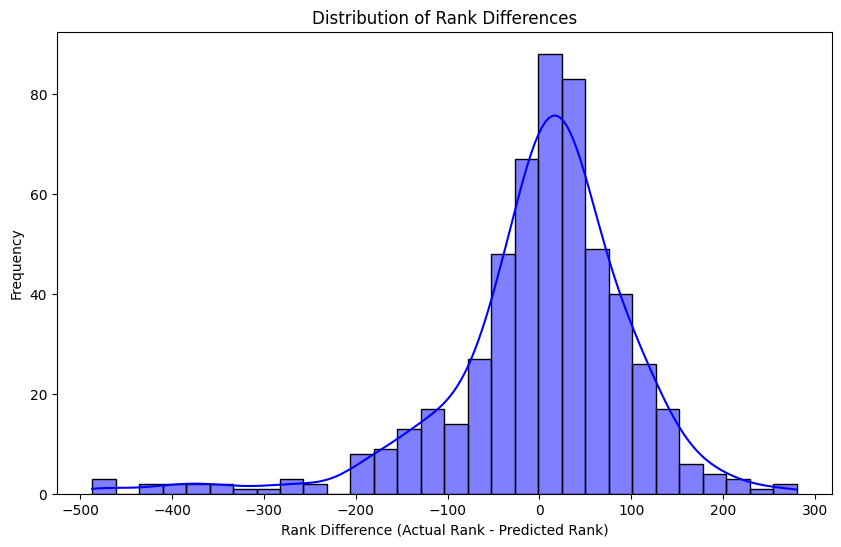

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制 rank_difference 的分布图
plt.figure(figsize=(10, 6))
sns.histplot(large_rank_diff['rank_difference'], bins=30, kde=True, color='blue')
plt.title('Distribution of Rank Differences')
plt.xlabel('Rank Difference (Actual Rank - Predicted Rank)')
plt.ylabel('Frequency')
plt.show()
